# H1-B Visa Petitions

In [1]:
# data reading
import requests
from io import BytesIO
from zipfile import ZipFile
import re
from concurrent.futures import ThreadPoolExecutor

# data processing
import pandas as pd
import numpy as np
import datetime

# visualising
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# analysing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

## 1. Overall Summary

### 1.1 Data Source
The Office of Foreign Labor Certification (OFLC) generates data on visa programs including the H1-B visa.Here I use the 2016, 2015 and the 2014 datasets to process my analyse.

### 1.2 Steps
#### a. Reading Data from the US immigration department
1.Read the data (three options: a. Request data from the official website; b. Download the xlsx file to the local machine and read it directly; c. Compress the data into a zip file and then read it).  

2.Compare whether the column names of each dataframe are the same, and if so, merge the data into one dataframe. 

#### b. Cleaning Data
1. Check data quality using isnull() and duplicated().
2. Format the data using astype(), str.lower(), and str.upper().
3. Handle duplicate values using drop_duplicates().
4. Handle missing values using fillna() and dropna().
5. Handle outliers by identifying them using the quartile method.

#### c. Analysing Data
1. PETITION

    · Distribution across time;
    · Average processing time;
    · Geographic distribution

2. EMPLOYER     

    · Q1: Analyse the number of applications by employer (EMPLOYER_NAME), and find the top 10 employers with the most applications;
    
    · Analyse the geographic distribution of employers, and find the top 10 states with the most employers and the top three cities in each state;
    
    · Use choropleth map to show the distribution of data in each state; 
    
3. JOB

    · Analyse the number of job applications in SOC_NAME column and find the top 10 most applied job titles.  
    · What is the number of successful and failed applications for each job?
    
4. WAGE 

    · Distribution of wages
    · Q2: Is the applicant wage correlated with petition success?

#### d. Additional Analysis
1. 考虑职业类型后再计算薪资水平与申请成功率的相关性

## 2. Data Poccessing

### 2.1 Read Data

If you don't want to download datasets into your local pc, please run the block below:

In [ ]:
# download dataset
url1 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY16.xlsx"
url2 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_Disclosure_Data_FY15_Q4.xlsx"
url3 = "https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/H-1B_FY14_Q4.xlsx"

df16_raw = pd.read_excel(url1)
df15_raw = pd.read_excel(url2)
df14_raw = pd.read_excel(url3)

print("Dataset 1 shape:", df14_raw.shape)
print("Dataset 2 shape:", df15_raw.shape)
print("Dataset 3 shape:", df16_raw.shape)

Otherwise, you can download the three datasets locally and compress them into a zip file called raw_data.zip before reading them (which will be faster!)

In [3]:
# open .zip
with ZipFile('raw_data.zip', 'r') as zipfile:
    # read raw .xlsx files and store them 
    df14_raw = pd.read_excel(zipfile.open('H-1B_FY14_Q4.xlsx'))
    df15_raw = pd.read_excel(zipfile.open('H-1B_Disclosure_Data_FY15_Q4.xlsx'))
    df16_raw = pd.read_excel(zipfile.open('H-1B_Disclosure_Data_FY16.xlsx'))

In [11]:
import zipfile

def process_file(file_name, xlsx_file, chunksize):
    df = pd.read_excel(xlsx_file, sheet_name= 0)
    chunks = [df[i:i + chunksize] for i in range(0, len(df), chunksize)]
    result_df = pd.DataFrame()
    for chunk in chunks:
        processed_chunk = process_chunk(chunk)
        result_df = pd.concat([result_df, processed_chunk])
    return file_name, result_df

chunksize = 10000  # 设置每个数据块的大小
archive_path = 'raw_data.zip'

# 创建一个字典来存储每个文件的结果 DataFrame
result_dfs = {}

# 使用 zipfile 打开压缩文件
with zipfile.ZipFile(archive_path, 'r') as zf:
    # 遍历压缩包中的每个文件
    xlsx_files = [file_name for file_name in zf.namelist() if file_name.endswith('.xlsx')]
    
    # 使用 ThreadPoolExecutor 进行并行处理
    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in xlsx_files:
            xlsx_file = zf.open(file_name)
            futures.append(executor.submit(process_file, file_name, xlsx_file, chunksize))
        
        # 获取并行处理的结果
        for future in futures:
            file_name, result_df = future.result()
            result_dfs[file_name] = result_df

# 将结果分别赋值给 df14_raw、df15_raw 和 df16_raw
df14_raw = result_dfs['H-1B_FY14_Q4.xlsx']
df15_raw = result_dfs['H-1B_Disclosure_Data_FY15_Q4.xlsx']
df16_raw = result_dfs['H-1B_Disclosure_Data_FY16.xlsx']

AttributeError: 'ZipFile' object has no attribute 'zipfile'

### 2.2 Drop unnecessary columns

In [4]:
# merge columns
df15_raw['EMPLOYER_ADDRESS'] = df15_raw.apply(lambda x: f"{x['EMPLOYER_ADDRESS1']} {x['EMPLOYER_ADDRESS2']}" if pd.notnull(x['EMPLOYER_ADDRESS2']) else x['EMPLOYER_ADDRESS1'], axis=1)

# remove 'EMPLOYER_ADDRESS1' and 'EMPLOYER_ADDRESS2' columns
df15_raw.drop(['EMPLOYER_ADDRESS1', 'EMPLOYER_ADDRESS2'], axis=1, inplace=True)

df15_raw.head()

CASE_NUMBER CASE_STATUS CASE_SUBMITTED DECISION_DATE VISA_CLASS  \
0  I-200-09121-701936   WITHDRAWN     2015-02-05    2015-02-05       H-1B   
1  I-200-09146-796321   CERTIFIED     2014-12-12    2014-12-18       H-1B   
2  I-200-09180-329758   WITHDRAWN     2013-01-03    2014-12-15       H-1B   
3  I-200-09183-259985   CERTIFIED     2015-03-10    2015-03-16       H-1B   
4  I-200-09189-800933   CERTIFIED     2014-12-17    2014-12-23       H-1B   

  EMPLOYMENT_START_DATE EMPLOYMENT_END_DATE                    EMPLOYER_NAME  \
0            02/09/2015          02/28/2015                  MEDTRONIC, INC.   
1            01/05/2015          01/04/2018           UNIVERSITY OF OKLAHOMA   
2            01/07/2013          01/06/2016                       NOKIA INC.   
3            09/07/2015          09/07/2018  OMRON OILFIELD AND MARINE, INC.   
4            06/06/2015          06/05/2018   FEDERAL HOME LOAN MORTGAGE CO.   

  EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE          EMPLOYER_COUNTRY  \
0   MINNEAPOLIS             MN                55432  UNITED STATES OF AMERICA   
1        NORMAN             OK                73019  UNITED STATES OF AMERICA   
2        IRVING             TX                75039  UNITED STATES OF AMERICA   
3       HOUSTON             TX                77088  UNITED STATES OF AMERICA   
4        MCLEAN             VA                22102  UNITED STATES OF AMERICA   

  EMPLOYER_PROVINCE  EMPLOYER_PHONE  EMPLOYER_PHONE_EXT AGENT_ATTORNEY_NAME  \
0               NaN   7635052710.00                 NaN     DEBRA SCHNEIDER   
1               NaN   4053251826.00                 NaN                 NaN   
2               NaN   9728945000.00                 NaN         HASEENA ENU   
3               NaN   7138491700.00                 NaN        ELDON KAKUDA   
4               NaN   7039188838.00                 NaN     JAMES ALEXANDER   

  AGENT_ATTORNEY_CITY AGENT_ATTORNEY_STATE                          JOB_TITLE  \
0         MINNEAPOLIS                   MN                MECHANICAL ENGINEER   
1                 NaN                  NaN                ASSISTANT PROFESSOR   
2              DALLAS                   TX  RELEASE AND SOFTWARE TEST MANAGER   
3          SCHAUMBURG                   IL     CONTROL ENGINEERING SPECIALIST   
4          WASHINGTON                   DC                 DEVELOPMENT SENIOR   

     SOC_CODE                                SOC_NAME  NAIC_CODE  \
0  17-2141.00                    MECHANICAL ENGINEERS  334510.00   
1     25-1032     ENGINEERING TEACHERS, POSTSECONDARY  611310.00   
2     15-1799        COMPUTER OCCUPATIONS, ALL OTHER*  517212.00   
3     17-2072  ELECTRONICS ENGINEERS, EXCEPT COMPUTER  335314.00   
4     15-1131                    COMPUTER PROGRAMMERS  522294.00   

   TOTAL WORKERS FULL_TIME_POSITION  PREVAILING_WAGE PW_UNIT_OF_PAY  \
0           1.00                  Y         19000.00           Year   
1           1.00                  Y         42860.00           Year   
2           1.00                  Y         73965.00           Year   
3           2.00                  Y         65998.00           Year   
4           1.00                  Y         96907.00           Year   

  PW_WAGE_LEVEL PW_WAGE_SOURCE  PW_WAGE_SOURCE_YEAR     PW_WAGE_SOURCE_OTHER  \
0       Level I            OES              2014.00       ONLINE DATA SURVEY   
1       Level I          Other              2014.00  OFLC ONLINE DATA CENTER   
2      Level II            OES              2012.00  OFLC ONLINE DATA CENTER   
3       Level I            OES              2014.00  OFLC ONLINE DATA CENTER   
4      Level IV            OES              2014.00  OFLC ONLINE DATA CENTER   

  WAGE_RATE_OF_PAY WAGE_UNIT_OF_PAY H-1B_DEPENDENT WILLFUL VIOLATOR  \
0          20000 -             Year              N                N   
1       85000.00 -             Year              N                N   
2          94000 -             Year              N                N   
3    66000 - 700

### 2.3 Clean Column Names 

In [5]:
datasets = [df14_raw, df15_raw, df16_raw]

for i, dataset in enumerate(datasets):
    print(f"columns' name of dataframe {i + 1} ：")
    print(dataset.columns)
    print("\n")

columns' name of dataframe 1 ：
Index(['LCA_CASE_NUMBER', 'STATUS', 'LCA_CASE_SUBMIT', 'DECISION_DATE',
       'VISA_CLASS', 'LCA_CASE_EMPLOYMENT_START_DATE',
       'LCA_CASE_EMPLOYMENT_END_DATE', 'LCA_CASE_EMPLOYER_NAME',
       'LCA_CASE_EMPLOYER_ADDRESS', 'LCA_CASE_EMPLOYER_CITY',
       'LCA_CASE_EMPLOYER_STATE', 'LCA_CASE_EMPLOYER_POSTAL_CODE',
       'LCA_CASE_SOC_CODE', 'LCA_CASE_SOC_NAME', 'LCA_CASE_JOB_TITLE',
       'LCA_CASE_WAGE_RATE_FROM', 'LCA_CASE_WAGE_RATE_TO',
       'LCA_CASE_WAGE_RATE_UNIT', 'FULL_TIME_POS', 'TOTAL_WORKERS',
       'LCA_CASE_WORKLOC1_CITY', 'LCA_CASE_WORKLOC1_STATE', 'PW_1',
       'PW_UNIT_1', 'PW_SOURCE_1', 'OTHER_WAGE_SOURCE_1', 'YR_SOURCE_PUB_1',
       'LCA_CASE_WORKLOC2_CITY', 'LCA_CASE_WORKLOC2_STATE', 'PW_2',
       'PW_UNIT_2', 'PW_SOURCE_2', 'OTHER_WAGE_SOURCE_2', 'YR_SOURCE_PUB_2',
       'LCA_CASE_NAICS_CODE'],
      dtype='object')


columns' name of dataframe 2 ：
Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
  

In [6]:
# Mapping different column names to the same standard column name
column_name_mapping = {
    'LCA_CASE_NUMBER': 'CASE_NUMBER',
    'LCA_CASE_SUBMIT': 'CASE_SUBMITTED',
    'STATUS': 'CASE_STATUS',
    'LCA_CASE_EMPLOYMENT_START_DATE': 'EMPLOYMENT_START_DATE',
    'LCA_CASE_EMPLOYMENT_END_DATE': 'EMPLOYMENT_END_DATE',
    'LCA_CASE_EMPLOYER_NAME': 'EMPLOYER_NAME',
    'LCA_CASE_EMPLOYER_ADDRESS': 'EMPLOYER_ADDRESS',
    'LCA_CASE_EMPLOYER_CITY': 'EMPLOYER_CITY',
    'LCA_CASE_EMPLOYER_STATE': 'EMPLOYER_STATE',
    'LCA_CASE_EMPLOYER_POSTAL_CODE': 'EMPLOYER_POSTAL_CODE',
    'LCA_CASE_SOC_CODE': 'SOC_CODE',
    'LCA_CASE_SOC_NAME': 'SOC_NAME',
    'LCA_CASE_JOB_TITLE': 'JOB_TITLE',
    'LCA_CASE_WAGE_RATE_FROM': 'WAGE_RATE_OF_PAY_FROM',
    'LCA_CASE_WAGE_RATE_TO': 'WAGE_RATE_OF_PAY_TO',
    'LCA_CASE_WAGE_RATE_UNIT': 'WAGE_UNIT_OF_PAY',
    'FULL_TIME_POS': 'FULL_TIME_POSITION',
    'TOTAL_WORKERS': 'TOTAL_WORKERS',
    'LCA_CASE_WORKLOC1_CITY': 'WORKSITE_CITY',
    'LCA_CASE_WORKLOC1_STATE': 'WORKSITE_STATE',
    'PW_1': 'PREVAILING_WAGE',
    'PW_UNIT_1': 'PW_UNIT_OF_PAY',
    'PW_SOURCE_1': 'PW_WAGE_SOURCE',
    'OTHER_WAGE_SOURCE_1': 'PW_SOURCE_OTHER',
    'YR_SOURCE_PUB_1': 'PW_SOURCE_YEAR',
    'LCA_CASE_NAICS_CODE': 'NAIC_CODE',
}

In [7]:
# Rename the column names using the mapping dictionary to make the column names consistent across the three datasets
df14 = df14_raw.rename(columns=column_name_mapping)
df15 = df15_raw.rename(columns=column_name_mapping)
df16 = df16_raw.rename(columns=column_name_mapping)

In [8]:
columns_df14 = set(df14.columns)
columns_df15 = set(df15.columns)
columns_df16 = set(df16.columns)

unique_df14 = columns_df14.difference(columns_df15).difference(columns_df16)
unique_df15 = columns_df15.difference(columns_df14).difference(columns_df16)
unique_df16 = columns_df16.difference(columns_df14).difference(columns_df15)

print("columns only in df14：", unique_df14)
print("columns only in df15：", unique_df15)
print("columns only in df16：", unique_df16)

columns only in df14： {'YR_SOURCE_PUB_2', 'PW_SOURCE_2', 'PW_2', 'PW_UNIT_2', 'LCA_CASE_WORKLOC2_CITY', 'OTHER_WAGE_SOURCE_2', 'LCA_CASE_WORKLOC2_STATE'}
columns only in df15： {'WILLFUL VIOLATOR', 'WAGE_RATE_OF_PAY', 'PW_WAGE_SOURCE_OTHER', 'TOTAL WORKERS', 'PW_WAGE_SOURCE_YEAR', 'PW_WAGE_LEVEL'}
columns only in df16： {'WILLFUL_VIOLATOR', 'ORIGINAL_CERT_DATE'}


### 2.4 Merge Data

In [9]:
merged_data = pd.concat([df14, df15, df16], axis=0, ignore_index=True, join="outer")

In [10]:
merged_data.head()

CASE_NUMBER          CASE_STATUS      CASE_SUBMITTED  \
0  I-200-09106-546545  CERTIFIED-WITHDRAWN 2013-01-18 18:05:43   
1  I-200-09162-143337            CERTIFIED 2014-03-17 11:11:45   
2  I-200-09182-550211               DENIED 2014-03-14 17:05:01   
3  I-200-09193-873099            CERTIFIED 2014-03-01 12:37:02   
4  I-200-09197-120609  CERTIFIED-WITHDRAWN 2014-03-10 15:33:41   

        DECISION_DATE VISA_CLASS EMPLOYMENT_START_DATE  EMPLOYMENT_END_DATE  \
0 2014-09-29 15:59:50       H-1B   2013-02-01 00:00:00  2016-02-01 00:00:00   
1 2014-03-21 23:11:51       H-1B   2014-09-15 00:00:00  2017-09-15 00:00:00   
2 2014-03-20 16:59:49       H-1B   2014-04-01 00:00:00  2015-04-01 00:00:00   
3 2014-03-06 22:03:37       H-1B   2014-08-28 00:00:00  2017-08-27 00:00:00   
4 2014-03-17 10:52:46       H-1B   2014-09-01 00:00:00  2017-09-01 00:00:00   

                       EMPLOYER_NAME           EMPLOYER_ADDRESS  \
0  TEXAS STATE UNIVERSITY-SAN MARCOS       601 UNIVERSITY DRIVE   
1   EYE SPECIALISTS OF INDIANA, P.C.       1901 N. MERIDIAN ST.   
2                          LHB, INC.    21 WEST SUPERIOR STREET   
3                      WAM USA, INC.     75 BOULDERBROOK CIRCLE   
4           DFUSE TECHNOLOGIES, INC.  20143 DESERT FOREST DRIVE   

   EMPLOYER_CITY EMPLOYER_STATE EMPLOYER_POSTAL_CODE SOC_CODE  \
0     SAN MARCOS             TX                78666  19-1029   
1   INDIANAPOLIS             IN                46202  29-1041   
2         DULUTH             MN                55802  27-2011   
3  LAWRENCEVILLE             GA                30045  13-2011   
4        ASHBURN             VA                20147  15-1131   

                           SOC_NAME                        JOB_TITLE  \
0  Biological Scientists, All Other  POSTDOCTORAL RESEARCH ASSOCIATE   
1                      Optometrists                      OPTOMETRIST   
2                            Actors            FOOD SAFETY SCIENTIST   
3          Accountants and Auditors         INTERNATIONAL ACCOUNTANT   
4              Computer Programmers               PROGRAMMER ANALYST   

   WAGE_RATE_OF_PAY_FROM  WAGE_RATE_OF_PAY_TO WAGE_UNIT_OF_PAY  \
0               50000.00             60000.00             Year   
1               65000.00                  NaN             Year   
2               50000.00                  NaN             Year   
3               48000.00                  NaN             Year   
4               62000.00                  NaN             Year   

  FULL_TIME_POSITION  TOTAL_WORKERS  WORKSITE_CITY WORKSITE_STATE  \
0                  Y           1.00     SAN MARCOS             TX   
1                  Y           1.00   INDIANAPOLIS             IN   
2                  Y           1.00           FARG             WI   
3                  Y           1.00  LAWRENCEVILLE             GA   
4                  Y           1.00       SAN JOSE             CA   

   PREVAILING_WAGE PW_UNIT_OF_PAY PW_WAGE_SOURCE          PW_SOURCE_OTHER  \
0         43118.00           Year            OES  OFLC ONLINE DATA CENTER   
1         64251.00           Year          Other  OFLC ONLINE DATA CENTER   
2         50000.00           Year            OES             OFLIC ONLINE   
3         47424.00           Year          Other  OFLC ONLINE DATA CENTER   
4         61589.00           Year            OES  OFLC ONLINE DATA CENTER   

   PW_SOURCE_YEAR LCA_CASE_WORKLOC2_CITY LCA_CASE_WORKLOC2_STATE     PW_2  \
0         2013.00              ST. LOUIS                      MO 49566.00   
1         2013.00           INDIANAPOLIS                      IN 64251.00   
2         2014.00                    NaN                     NaN      NaN   
3         2014.00                    NaN                     NaN      NaN   
4         2013.00                    NaN                     NaN      NaN   

  PW_UNIT_2 PW_SOURCE_2      OTHER_WAGE_SOURCE_2          YR_SOURCE_PUB_2  \
0      Year         OES  OFLC ONLINE DATA CENTER  OFLC ONLINE DATA CENTER   
1      Year       O

In [19]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786160 entries, 0 to 1786159
Data columns (total 53 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   CASE_NUMBER              object        
 1   CASE_STATUS              object        
 2   CASE_SUBMITTED           datetime64[ns]
 3   DECISION_DATE            datetime64[ns]
 4   VISA_CLASS               object        
 5   EMPLOYMENT_START_DATE    object        
 6   EMPLOYMENT_END_DATE      object        
 7   EMPLOYER_NAME            object        
 8   EMPLOYER_ADDRESS         object        
 9   EMPLOYER_CITY            object        
 10  EMPLOYER_STATE           object        
 11  EMPLOYER_POSTAL_CODE     object        
 12  SOC_CODE                 object        
 13  SOC_NAME                 object        
 14  JOB_TITLE                object        
 15  WAGE_RATE_OF_PAY_FROM    float64       
 16  WAGE_RATE_OF_PAY_TO      float64       
 17  WAGE_UNIT_OF_PAY         ob

### 2.5 Tidying

In [11]:
# choose 1000 rows randomly for running code quickly
df_sample = merged_data.sample(n=100000)
df_sample.head()

#df_sample = merged_data
#df_sample.head()

CASE_NUMBER          CASE_STATUS      CASE_SUBMITTED  \
14477    I-200-13010-977913            WITHDRAWN 2014-01-10 19:19:02   
782131   I-200-15064-010974  CERTIFIED-WITHDRAWN 2015-03-05 00:00:00   
1144833  I-200-16118-472113            CERTIFIED 2016-04-27 00:00:00   
1293460  I-200-16083-744641            CERTIFIED 2016-03-23 00:00:00   
783026   I-200-15064-131562            CERTIFIED 2015-03-05 00:00:00   

              DECISION_DATE VISA_CLASS EMPLOYMENT_START_DATE  \
14477   2014-01-15 16:03:04       H-1B   2014-02-01 00:00:00   
782131  2015-09-25 00:00:00       H-1B            09/01/2015   
1144833 2016-05-03 00:00:00       H-1B   2016-09-01 00:00:00   
1293460 2016-03-29 00:00:00       H-1B   2016-09-22 00:00:00   
783026  2015-03-11 00:00:00       H-1B            09/04/2015   

         EMPLOYMENT_END_DATE                      EMPLOYER_NAME  \
14477    2017-02-01 00:00:00               RTKL ASSOCIATES INC.   
782131            06/30/2018                   ANG INFOTECH LLC   
1144833  2019-08-31 00:00:00                     TECHNOGEN INC.   
1293460  2019-09-21 00:00:00  VERINON TECHNOLOGY SOLUTIONS LTD.   
783026            09/03/2018              VSQUARE INFOTECH INC.   

                                 EMPLOYER_ADDRESS      EMPLOYER_CITY  \
14477                       901 SOUTH BOND STREET          BALTIMORE   
782131                           23 SEQUOIA DRIVE             DAYTON   
1144833                  4229 LAFAYETTE CENTER DR          CHANTILLY   
1293460         3395 NORTH ARLINGTON HEIGHTS ROAD  ARLINGTON HEIGHTS   
783026   485 US HIGHWAY 1 S BUILDING C, SUITE 105             ISELIN   

        EMPLOYER_STATE EMPLOYER_POSTAL_CODE SOC_CODE  \
14477               MD                21231  17-1011   
782131              NJ                08810  15-1121   
1144833             VA                20151  11-2022   
1293460             IL                60004  15-1121   
783026              NJ                08830  15-1131   

                                       SOC_NAME  \
14477    Architects, Except Landscape and Naval   
782131                COMPUTER SYSTEMS ANALYSTS   
1144833                          SALES MANAGERS   
1293460               COMPUTER SYSTEMS ANALYSTS   
783026                     COMPUTER PROGRAMMERS   

                              JOB_TITLE  WAGE_RATE_OF_PAY_FROM  \
14477                  INTERN ARCHITECT               48175.00   
782131                  SYSTEMS ANALYST                    NaN   
1144833  MANAGER , SALES AND OPERATIONS              120000.00   
1293460                     IT ANALAYST               56514.00   
783026               PROGRAMMER ANALYST                    NaN   

         WAGE_RATE_OF_PAY_TO WAGE_UNIT_OF_PAY FULL_TIME_POSITION  \
14477                    NaN             Year                  Y   
782131                   NaN             Year                  Y   
1144833                 0.00             Year                NaN   
1293460                 0.00             Year                NaN   
783026                   NaN             Year                  Y   

         TOTAL_WORKERS      WORKSITE_CITY WORKSITE_STATE  PREVAILING_WAGE  \
14477             1.00        LOS ANGELES             CA         46400.00   
782131             NaN           NEW YORK             NY         63086.00   
1144833           1.00          CHANTILLY             VA        110448.00   
1293460           1.00  ARLINGTON HEIGHTS             IL         56514.00   
783026             NaN           BLUFFTON             SC         36566.00   

        PW_UNIT_OF_PAY PW_WAGE_SOURCE               PW_SOURCE_OTHER  \
14477             Year          Other  2013 AIA COMPENSATION REPORT   
782131            Year            OES                           NaN   
1144833           Year            OES       OFLC ONLINE DATA CENTER   
1293460           Year            OES       OFLC ONLINE DATA CENTER   
783026            Year          Other                           NaN   

         PW_SOURCE_YEA

#### 2.5.1 Strings to lowercase letters

In [12]:
df_sample.columns = [col.lower() for col in df_sample.columns]

for column in df_sample.columns:
    if df_sample[column].dtype == 'object':
        df_sample[column] = df_sample[column].str.lower()

#### 2.5.2 remove duplications

In [13]:
duplicate_rows = df_sample.duplicated()
print(duplicate_rows)

14477      False
782131     False
1144833    False
1293460    False
783026     False
           ...  
1734253    False
1375948    False
1350624    False
808043     False
1471613    False
Length: 100000, dtype: bool


In [14]:
df_sample = df_sample.drop_duplicates()
#df_sample.info()

#### 2.5.3 deal with missing data

· fill in missing values

    The data point 0 in wage_rate_of_pay_to should mean no upper limit, replace with NA.

· remove non-essential columns 

    Columns with 2 in the column name;
    Columns whose column names begin with agent_;
    employer_province, employer_phone, employer_phone_ext

In [15]:
missing_values = df_sample.isnull().sum()
print(missing_values)

case_number                    0
case_status                    0
case_submitted                 0
decision_date                  0
visa_class                     0
employment_start_date      65637
employment_end_date        65637
employer_name                  3
employer_address               2
employer_city                  1
employer_state                 8
employer_postal_code           5
soc_code                       4
soc_name                     218
job_title                      3
wage_rate_of_pay_from      34363
wage_rate_of_pay_to        57646
wage_unit_of_pay               2
full_time_position         36451
total_workers              34363
worksite_city                  2
worksite_state                 2
prevailing_wage               12
pw_unit_of_pay                13
pw_wage_source                12
pw_source_other            35466
pw_source_year             34369
lca_case_workloc2_city     95291
lca_case_workloc2_state    95290
pw_2                       95290
pw_unit_2 

##### a. Fill missing values
The data point 0 in wage_rate_of_pay_to should mean uncapped and be replaced by NA;

In [16]:
df_sample['wage_rate_of_pay_to'] = df_sample['wage_rate_of_pay_to'].replace(0, np.nan)

##### b. remove non-essential columns

In [17]:
# Columns with 2 and agent_ in the column name
columns_to_drop = [col for col in df_sample.columns if '2' in col or 'agent' in col]

columns_to_drop.extend(['employer_province', 'employer_phone', 'employer_phone_ext'])

df_sample = df_sample.drop(columns_to_drop, axis=1)

#### 2.5.4 deal with missing data in wages

##### a. column 'wage_rate_of_pay'

For values in this column that are not NA, perform the following:

    1. remove error values：    
    
        · Digits larger than eight digits (may be a wrongly filled in phone number)   
        · Repeated numbers, e.g. 23.622362   
        
    2. Modify the number format:      
    
        · num1 - num2: calculate the average wages   
        · num - : remove "-" then convert them into float or int

In [18]:
def process_wage_and_return_original(row):
    value = row['wage_rate_of_pay']
    if pd.isna(value) or value.strip() == '-':
        return None, None

    # dealing with values countaining "-"
    pattern = r'(\d+(?:\.\d{1,2})?)(?:\s?-\s?(\d+(?:\.\d{1,2})?))?'
    match = re.match(pattern, value)
    if match:
        num1 = float(match.group(1))
        num2 = match.group(2)
        if num2:
            num2 = float(num2)
            return value, (num1 + num2) / 2
        return value, num1

    # dealing with repeat numbers
    str_value = str(value)
    if len(str_value) > 7:
        processed_value = float(str_value[:str_value.find(str_value[4:])])
        return value, processed_value

    # remove values that digits larger than eight digits 
    if len(str(value)) >= 8:
        return value, None

    return value, float(value)

In [19]:
temp_df = df_sample.apply(process_wage_and_return_original, axis=1, result_type='expand')
temp_df.columns = ['original_wage', 'calculated_wage']

#checking processed values to make sure every error value has been dealt with
df_sample = pd.concat([df_sample, temp_df], axis=1)
processed_rows = df_sample[df_sample['wage_rate_of_pay'] != df_sample['calculated_wage']]

print(processed_rows[['wage_rate_of_pay','calculated_wage']])

        wage_rate_of_pay  calculated_wage
14477                NaN              NaN
782131           63086 -         63086.00
1144833              NaN              NaN
1293460              NaN              NaN
783026        36566.00 -         36566.00
...                  ...              ...
1734253              NaN              NaN
1375948              NaN              NaN
1350624              NaN              NaN
808043        52499.00 -         52499.00
1471613              NaN              NaN

[100000 rows x 2 columns]


In [20]:
print(df_sample['calculated_wage'].describe())

count      34363.00
mean       79455.64
std        72311.32
min            8.06
25%        60000.00
50%        72200.00
75%        94974.25
max     11000000.00
Name: calculated_wage, dtype: float64


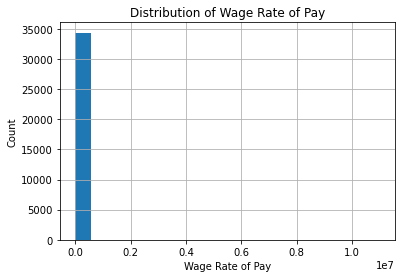

In [21]:
# bar plot
df_sample['calculated_wage'].hist(bins=20)
plt.title('Distribution of Wage Rate of Pay')
plt.xlabel('Wage Rate of Pay')
plt.ylabel('Count')
plt.show()

##### b. fill in missing values in wages
    b.1. Calculate the average of [wage_rate_of_pay_from] and [wage_rate_of_pay_to] as the salary of the applicant when both are not NA;
    
    b.2. If only [wage_rate_of_pay_from] is available, use that as the salary;
    
    b.3. If both [wage_rate_of_pay_from] and [wage_rate_of_pay_to] are NA, use [prevailing_wage] as the salary of the applicant;

    * It is necessary to distinguish by [pw_unit_of_pay] (year or hour).

In [22]:
def fill_calculated_wage(row):
    if pd.isna(row['calculated_wage']):
        if not pd.isna(row['wage_rate_of_pay_from']) and not pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = (row['wage_rate_of_pay_from'] + row['wage_rate_of_pay_to']) / 2
        elif not pd.isna(row['wage_rate_of_pay_from']) and pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = row['wage_rate_of_pay_from']
        elif pd.isna(row['wage_rate_of_pay_from']) and pd.isna(row['wage_rate_of_pay_to']):
            row['calculated_wage'] = row['prevailing_wage']
    return row

df_sample = df_sample.apply(fill_calculated_wage, axis=1)

##### c. checking errors and outliers in wages

In [23]:
df_hourly = df_sample[df_sample['wage_unit_of_pay'] == 'hour']
df_yearly = df_sample[df_sample['wage_unit_of_pay'] == 'year']

In [24]:
print(df_hourly['calculated_wage'].describe())

count     6486.00
mean       332.49
std       5285.98
min          7.13
25%         25.00
50%         31.67
75%         40.65
max     150000.00
Name: calculated_wage, dtype: float64


In [25]:
print(df_yearly['calculated_wage'].describe())

count      93351.00
mean       85536.55
std        56520.19
min        12500.00
25%        63000.00
50%        75000.00
75%        98220.00
max     11000000.00
Name: calculated_wage, dtype: float64


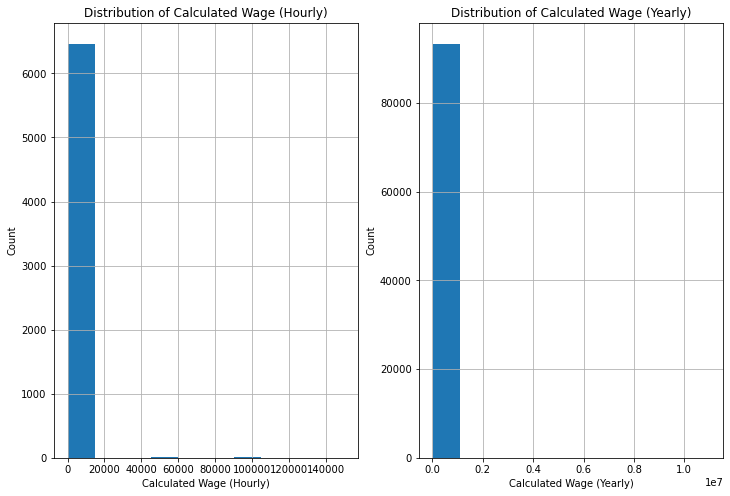

In [26]:
# bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
df_hourly['calculated_wage'].hist(ax=axes[0])
axes[0].set_title('Distribution of Calculated Wage (Hourly)')
axes[0].set_xlabel('Calculated Wage (Hourly)')
axes[0].set_ylabel('Count')
df_yearly['calculated_wage'].hist(ax=axes[1])
axes[1].set_title('Distribution of Calculated Wage (Yearly)')
axes[1].set_xlabel('Calculated Wage (Yearly)')
axes[1].set_ylabel('Count')
plt.show()

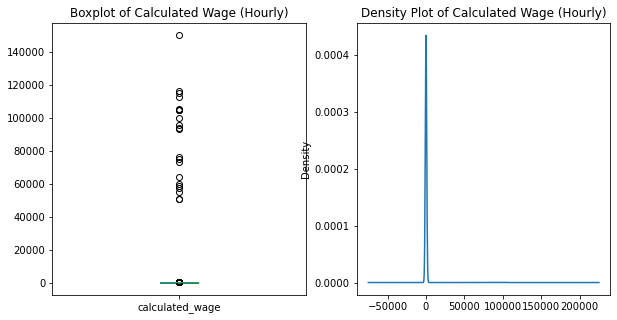

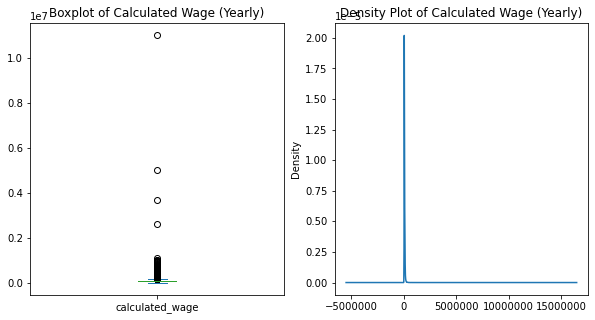

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df_hourly['calculated_wage'].plot(kind='box', ax=axes[0])
axes[0].set_title('Boxplot of Calculated Wage (Hourly)')
df_hourly['calculated_wage'].plot(kind='density', ax=axes[1])
axes[1].set_title('Density Plot of Calculated Wage (Hourly)')
axes[1].ticklabel_format(style='plain', axis='x')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
df_yearly['calculated_wage'].plot(kind='box', ax=axes[0])
axes[0].set_title('Boxplot of Calculated Wage (Yearly)')
df_yearly['calculated_wage'].plot(kind='density', ax=axes[1])
axes[1].set_title('Density Plot of Calculated Wage (Yearly)')
axes[1].ticklabel_format(style='plain', axis='x')
plt.show()

##### d. remove errors and outliers

In [28]:
# hourly wages
# remove outlier
q75_hourly= df_hourly['calculated_wage'].quantile(q=0.75)

# values lager than q75
outliers_hourly = df_hourly[df_hourly['calculated_wage'] > q75_hourly]

print(outliers_hourly['calculated_wage'].sort_values(ascending=False).head(20))

319593    150000.00
190103    116000.00
44394     115000.00
4245      112500.00
1433123   105550.00
551157    105000.00
673575    104799.00
1205332   104500.00
83784     100000.00
101273     95910.00
427412     93600.00
263309     93121.00
350978     76500.00
300871     74880.00
288987     72883.00
230075     64300.00
36071      60000.00
334275     58643.00
751693     57240.00
84533      55000.00
Name: calculated_wage, dtype: float64


In [29]:
# yearly wages
# remove outlier
q75_yearly= df_yearly['calculated_wage'].quantile(q=0.75)

# values lager than q75
outliers_yearly = df_yearly[df_yearly['calculated_wage'] > q75_yearly]

print(outliers_yearly['calculated_wage'].sort_values(ascending=False).head(20))

840556    11000000.00
372884     4999999.00
288578     3687800.00
1139053    2625000.00
1135592    1100000.00
517467     1000000.00
1692404     999000.00
361885      975000.00
85807       950000.00
773692      930000.00
26891       925000.00
1538968     920000.00
464016      890000.00
336020      850000.00
512822      800000.00
1132838     800000.00
1316541     750000.00
490460      750000.00
556132      744000.00
1168273     738000.00
Name: calculated_wage, dtype: float64


In [30]:
# run this block unless you find outliers
# find the row with error value
row_to_drop = outliers_yearly[outliers_yearly['calculated_wage'] > 1000000].index.union(
    outliers_hourly[outliers_hourly['calculated_wage'] > 130000].index)

# remove it
df_sample = df_sample.drop(row_to_drop)

In [45]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1786057 entries, 0 to 1786159
Data columns (total 42 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   case_number            object        
 1   case_status            object        
 2   case_submitted         datetime64[ns]
 3   decision_date          datetime64[ns]
 4   visa_class             object        
 5   employment_start_date  object        
 6   employment_end_date    object        
 7   employer_name          object        
 8   employer_address       object        
 9   employer_city          object        
 10  employer_state         object        
 11  employer_postal_code   object        
 12  soc_code               object        
 13  soc_name               object        
 14  job_title              object        
 15  wage_rate_of_pay_from  float64       
 16  wage_rate_of_pay_to    float64       
 17  wage_unit_of_pay       object        
 18  full_time_position    

In [32]:
df_sample.dropna(subset=['calculated_wage'], inplace=True)

In [31]:
#checking missing values again
missing_values = df_sample.isnull().sum()
print(missing_values)

case_number                  0
case_status                  0
case_submitted               0
decision_date                0
visa_class                   0
employment_start_date    65633
employment_end_date      65633
employer_name                3
employer_address             2
employer_city                1
employer_state               8
employer_postal_code         5
soc_code                     4
soc_name                   218
job_title                    3
wage_rate_of_pay_from    34361
wage_rate_of_pay_to      86276
wage_unit_of_pay             2
full_time_position       36450
total_workers            34361
worksite_city                2
worksite_state               2
prevailing_wage             12
pw_unit_of_pay              13
pw_wage_source              12
pw_source_other          35464
pw_source_year           34367
naic_code                    2
employer_country         29184
total workers            65633
pw_wage_level            67183
pw_wage_source_year      65639
pw_wage_

#### 2.5.5 common units of measurement

##### a. Calculating cases processing time and length of employment
    · case_processing_time (days) = decision_date - case_submitted  
    · employment_length (days) = employment_end_date - employment_start_date  

In [33]:
df_sample['decision_date'] = pd.to_datetime(df_sample['decision_date'], errors='coerce')
df_sample['case_submitted'] = pd.to_datetime(df_sample['case_submitted'], errors='coerce')
df_sample['case_processing_time'] = df_sample['decision_date'] - df_sample['case_submitted']

df_sample['employment_end_date'] = pd.to_datetime(df_sample['employment_end_date'], errors='coerce')
df_sample['employment_start_date'] = pd.to_datetime(df_sample['employment_start_date'], errors='coerce')
df_sample['employment_length'] = df_sample['employment_end_date'] - df_sample['employment_start_date']

df_sample.head()

/tmp/ipykernel_620/29738175.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sample['employment_end_date'] = pd.to_datetime(df_sample['employment_end_date'], errors='coerce')


case_number          case_status      case_submitted  \
14477    i-200-13010-977913            withdrawn 2014-01-10 19:19:02   
782131   i-200-15064-010974  certified-withdrawn 2015-03-05 00:00:00   
1144833  i-200-16118-472113            certified 2016-04-27 00:00:00   
1293460  i-200-16083-744641            certified 2016-03-23 00:00:00   
783026   i-200-15064-131562            certified 2015-03-05 00:00:00   

              decision_date visa_class employment_start_date  \
14477   2014-01-15 16:03:04       h-1b                   NaT   
782131  2015-09-25 00:00:00       h-1b            2015-09-01   
1144833 2016-05-03 00:00:00       h-1b                   NaT   
1293460 2016-03-29 00:00:00       h-1b                   NaT   
783026  2015-03-11 00:00:00       h-1b            2015-09-04   

        employment_end_date                      employer_name  \
14477                   NaT               rtkl associates inc.   
782131           2018-06-30                   ang infotech llc   
1144833                 NaT                     technogen inc.   
1293460                 NaT  verinon technology solutions ltd.   
783026           2018-09-03              vsquare infotech inc.   

                                 employer_address      employer_city  \
14477                       901 south bond street          baltimore   
782131                           23 sequoia drive             dayton   
1144833                  4229 lafayette center dr          chantilly   
1293460         3395 north arlington heights road  arlington heights   
783026   485 us highway 1 s building c, suite 105             iselin   

        employer_state employer_postal_code soc_code  \
14477               md                21231  17-1011   
782131              nj                08810  15-1121   
1144833             va                20151  11-2022   
1293460             il                60004  15-1121   
783026              nj                08830  15-1131   

                                       soc_name  \
14477    architects, except landscape and naval   
782131                computer systems analysts   
1144833                          sales managers   
1293460               computer systems analysts   
783026                     computer programmers   

                              job_title  wage_rate_of_pay_from  \
14477                  intern architect               48175.00   
782131                  systems analyst                    NaN   
1144833  manager , sales and operations              120000.00   
1293460                     it analayst               56514.00   
783026               programmer analyst                    NaN   

         wage_rate_of_pay_to wage_unit_of_pay full_time_position  \
14477                    NaN             year                  y   
782131                   NaN             year                  y   
1144833                  NaN             year                NaN   
1293460                  NaN             year                NaN   
783026                   NaN             year                  y   

         total_workers      worksite_city worksite_state  prevailing_wage  \
14477             1.00        los angeles             ca         46400.00   
782131             NaN           new york             ny         63086.00   
1144833           1.00          chantilly             va        110448.00   
1293460           1.00  arlington heights             il         56514.00   
783026             NaN           bluffton             sc         36566.00   

        pw_unit_of_pay pw_wage_source               pw_source_other  \
14477             year          other  2013 aia compensation report   
782131            year            oes                           NaN   
1144833           year            oes       oflc online data center   
1293460           year            oes       oflc online data center   
783026            year          other                           NaN   

         pw_source_year  nai

In [34]:
print(df_sample['case_processing_time'].describe())

count                          99994
mean      33 days 03:06:29.940096405
std      132 days 02:56:15.659742332
min                  0 days 00:00:00
25%                  6 days 00:00:00
50%                  6 days 00:00:00
75%           6 days 18:30:00.750000
max               1869 days 00:00:00
Name: case_processing_time, dtype: object


In [35]:
print(df_sample['employment_length'].describe())

count                           34361
mean     1041 days 22:36:43.730974080
std       169 days 12:10:23.299603350
min                   1 days 00:00:00
25%                1095 days 00:00:00
50%                1095 days 00:00:00
75%                1095 days 00:00:00
max                1096 days 00:00:00
Name: employment_length, dtype: object


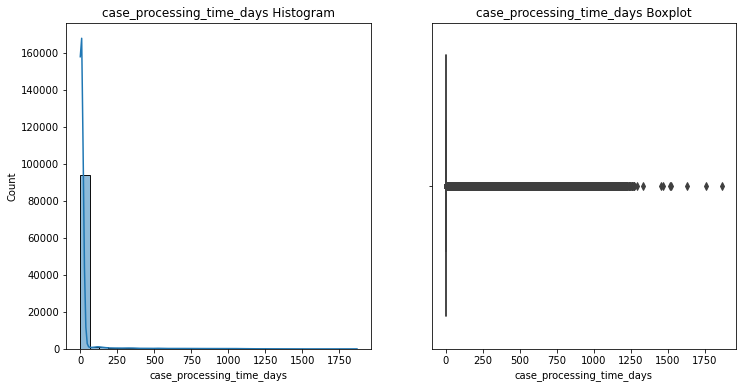

In [36]:
df_sample['case_processing_time_days'] = pd.to_datetime(df_sample['case_processing_time'], errors='coerce')

df_sample['case_processing_time_days'] = df_sample['case_processing_time'].dt.days


continuous_columns = ['case_processing_time_days']

for column in continuous_columns:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_sample, x=column, kde=True, bins=30)
    plt.title(f"{column} Histogram")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_sample, x=column)
    plt.title(f"{column} Boxplot")
    
    plt.show()

## 3. Data Analysis

Before we start the analysis, there're some extra columns need to be added. Here they are:

First we need a column to store the results that whether a case is successful.

In [37]:
df_sample['successful_petition'] = np.where(df_sample['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

Then we also need another column to restore the case results by string: successful or failed.

In [38]:
df_sample['case_outcome'] = df_sample['case_status'].apply(lambda x: 'successful' if x in ['certified', 'certified-withdrawn'] else 'failed')

We also need two new columns to additionally store the year and month of the case submission date.

In [39]:
# Extract year
df_sample['year'] = pd.to_datetime(df_sample['case_submitted']).dt.year
df_yearly['year'] = pd.to_datetime(df_yearly['case_submitted']).dt.year
df_hourly['year'] = pd.to_datetime(df_hourly['case_submitted']).dt.year

# Extract month
df_sample['month'] = pd.to_datetime(df_sample['case_submitted']).dt.month

### 3.1 Petitions

#### 3.1.1 Distribution of petitions across time

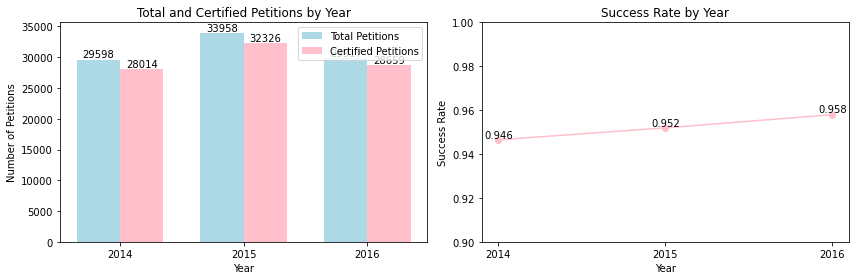

In [43]:
years = [2014, 2015, 2016]

# group by year and calculate total and successful petitions
yearly_data = df_sample[df_sample['year'].isin(years)].groupby('year', as_index=False).agg(
    {'successful_petition': 'sum', 'case_number': 'count'}
)

# calculate success rate
yearly_data['success_rate'] = yearly_data['successful_petition'] / yearly_data['case_number']

yearly_data['year'] = yearly_data['year'].astype(str)

# plotting bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# plot total and certified petitions
x = np.arange(len(years))
bar_width = 0.35

axes[0].bar(x - bar_width / 2, yearly_data['case_number'], bar_width, label="Total Petitions", color='lightblue')
axes[0].bar(x + bar_width / 2, yearly_data['successful_petition'], bar_width, label="Certified Petitions", color='pink')

# add numbers under bars
for i, row in yearly_data.iterrows():
    axes[0].text(i - bar_width / 2, row['case_number'], row['case_number'], ha='center', va='bottom')
    axes[0].text(i + bar_width / 2, row['successful_petition'], row['successful_petition'], ha='center', va='bottom')

axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Petitions")
axes[0].set_title("Total and Certified Petitions by Year")
axes[0].set_xticks(x)
axes[0].set_xticklabels(years)
axes[0].legend()

# plot success rate
axes[1].plot(yearly_data['year'], yearly_data['success_rate'], marker='o', color='pink')

# add numbers above markers
for i, row in yearly_data.iterrows():
    axes[1].text(row['year'], row['success_rate'], f'{row["success_rate"]:.3f}', ha='center', va='bottom')

axes[1].set_xlabel("Year")
axes[1].set_ylabel("Success Rate")
axes[1].set_title("Success Rate by Year")
axes[1].set_ylim([0.9, 1])

plt.tight_layout()
plt.show()

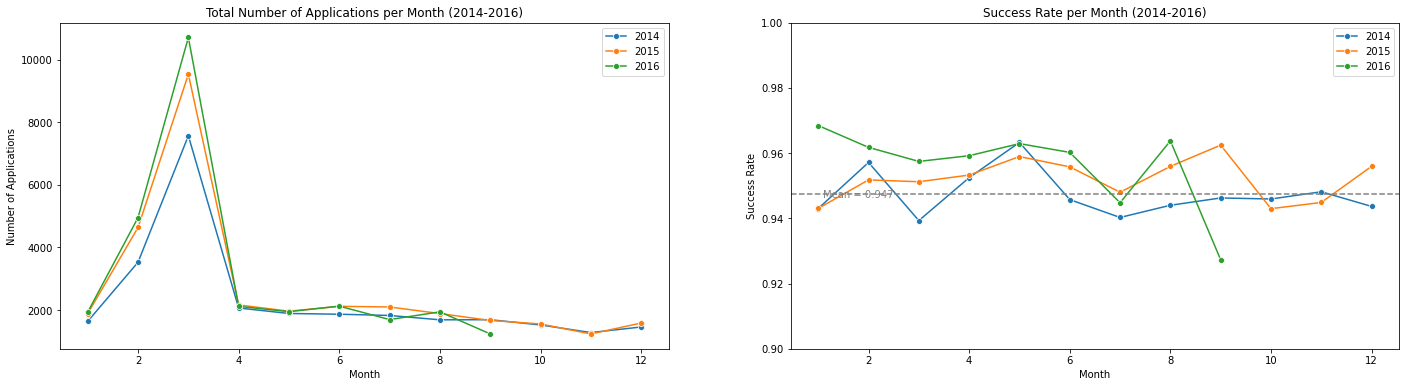

In [53]:
# Calculate the number of successful petitions for each month
monthly_success_data = selected_years_data.groupby(['year', 'month'], as_index=False)['successful_petition'].sum()

# Calculate the total number of petitions for each month
monthly_total_data = selected_years_data.groupby(['year', 'month'], as_index=False)['successful_petition'].count()

# Calculate the success rate for each month
monthly_data = monthly_success_data.copy()
monthly_data['success_rate'] = monthly_success_data['successful_petition'] / monthly_total_data['successful_petition']

# Create a subplot with two charts side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Plot the total number of applications per month for each year
sns.lineplot(ax=axes[0], data=monthly_data[monthly_data['year'] == 2014], x='month', y='successful_petition', marker='o', label='2014')
sns.lineplot(ax=axes[0], data=monthly_data[monthly_data['year'] == 2015], x='month', y='successful_petition', marker='o', label='2015')
sns.lineplot(ax=axes[0], data=monthly_data[monthly_data['year'] == 2016], x='month', y='successful_petition', marker='o', label='2016')

axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Applications')
axes[0].set_title('Total Number of Applications per Month (2014-2016)')
axes[0].legend()

# Plot the success rate per month for each year
sns.lineplot(ax=axes[1], data=monthly_data[monthly_data['year'] == 2014], x='month', y='success_rate', marker='o', label='2014')
sns.lineplot(ax=axes[1], data=monthly_data[monthly_data['year'] == 2015], x='month', y='success_rate', marker='o', label='2015')
sns.lineplot(ax=axes[1], data=monthly_data[monthly_data['year'] == 2016], x='month', y='success_rate', marker='o', label='2016')

# Add mean lines and annotations
mean_success_rate = monthly_data.groupby('year')['success_rate'].mean()
for year, ax in zip([2014, 2015, 2016], axes[1:]):
    ax.axhline(mean_success_rate[year], linestyle='--', color='grey')
    ax.text(1.1, mean_success_rate[year], f'Mean = {mean_success_rate[year]:.3f}', va='center', ha='left', color='grey')

axes[1].set_xlabel('Month')
axes[1].set_ylabel('Success Rate')
axes[1].set_title('Success Rate per Month (2014-2016)')
axes[1].legend()

# Set y-axis range for second chart
axes[1].set_ylim([0.9, 1])

plt.show()

H-1B申请数量在每年三月特别多的原因与美国移民局（USCIS）的H-1B配额和申请流程有关。H-1B签证有一个每年的配额限制，目前是65,000个名额，另外还有20,000个名额专门为美国硕士学位或更高学位的申请人设置。这些名额按照财政年度分配，财政年度从每年的10月1日开始。

美国移民局规定，企业最早可以在开始日期的六个月前提交H-1B申请。因此，对于以财政年度开始日期为准的H-1B申请，企业可以从每年的4月1日开始提交申请。通常，这个日期一到，许多雇主都会立即提交大量H-1B申请，以确保在名额用尽之前为员工获得签证。实际上，H-1B名额通常在短短几天内就被抢光。这就是为什么每年三月份的H-1B申请数量会特别多的原因。

#### 3.1.2 Average processing time of petitions

In [54]:
df_filtered = df_sample[(df_sample['year'] >= 2014) & (df_sample['year'] <= 2016)]

grouped_describe = df_filtered.groupby('case_outcome')['case_processing_time_days'].describe()
print(grouped_describe)

                count  mean    std  min  25%  50%  75%    max
case_outcome                                                 
failed        4474.00 28.17 113.06 0.00 0.00 3.00 6.00 966.00
successful   88999.00 16.09  62.70 3.00 6.00 6.00 6.00 996.00


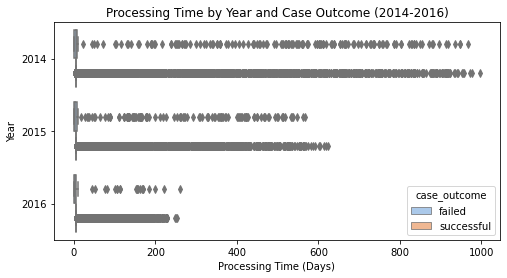

In [55]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_filtered, x='case_processing_time_days', y='year', hue='case_outcome', palette='pastel', orient='h')
plt.xlabel("Processing Time (Days)")
plt.ylabel("Year")
plt.title("Processing Time by Year and Case Outcome (2014-2016)")
plt.show()

To better observe the results, we can log case_processing_time_days:

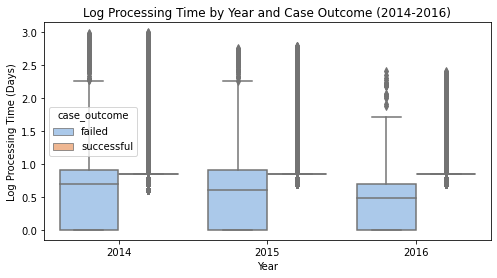

In [59]:
df_filtered = df_sample[df_sample['year'].isin([2014, 2015, 2016])].copy()

# log case_processing_time_days 
df_filtered.loc[:, 'log_case_processing_time_days'] = np.log10(df_filtered['case_processing_time_days'] + 1)

# plotting box-plot
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_filtered, x='year', y='log_case_processing_time_days', hue='case_outcome', palette='pastel')
plt.xlabel("Year")
plt.ylabel("Log Processing Time (Days)")
plt.title("Log Processing Time by Year and Case Outcome (2014-2016)")
plt.show()


结果：

#### 3.1.3 Geographic distribution of petitions

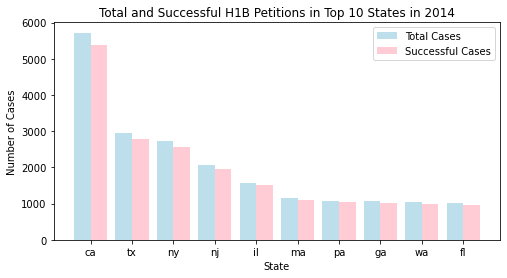

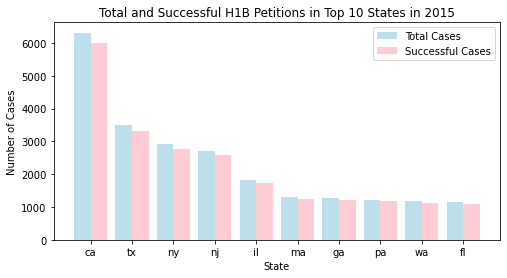

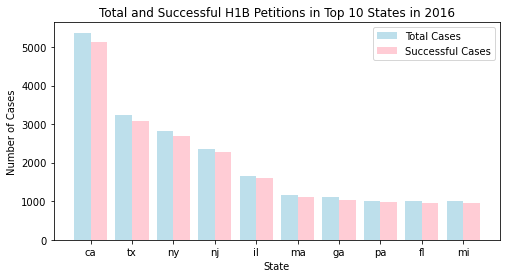

In [60]:
# count of successed and total petitions 
df_sample['case_count'] = 1
state_yearly_data = df_sample.groupby(['worksite_state', 'year']).agg({
    'successful_petition': 'sum',
    'case_count': 'count'
}).reset_index()

# ploting by years
years = [2014, 2015, 2016]

for year in years:
    current_year_data = state_yearly_data[state_yearly_data['year'] == year]
    top_10_states = current_year_data.nlargest(10, 'case_count')

    # bar plot
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(len(top_10_states['worksite_state']))
    width = 0.4

    ax.bar(x - width/2, top_10_states['case_count'], width, label='Total Cases', color='lightblue', alpha=0.8)
    ax.bar(x + width/2, top_10_states['successful_petition'], width, label='Successful Cases',color='pink', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(top_10_states['worksite_state'])
    ax.legend()
    ax.set_title(f'Total and Successful H1B Petitions in Top 10 States in {year}')
    ax.set_xlabel('State')
    ax.set_ylabel('Number of Cases')
    

    plt.show()

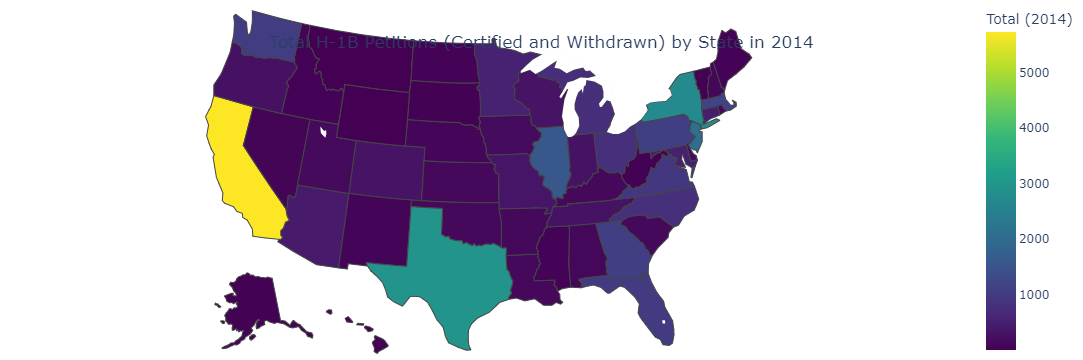

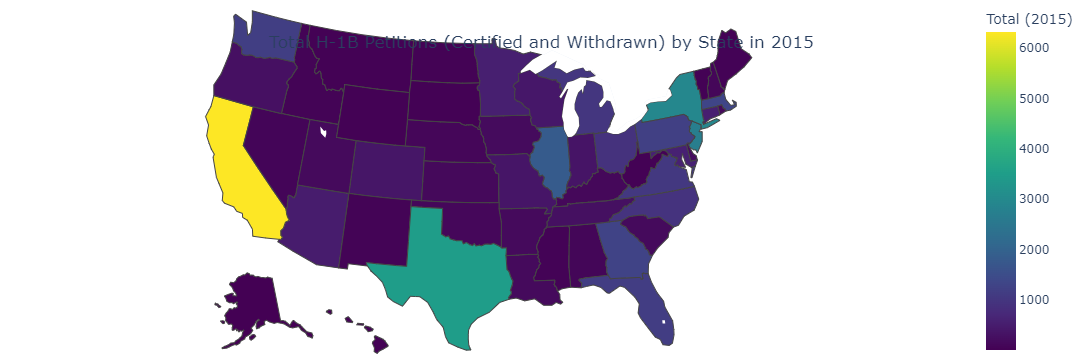

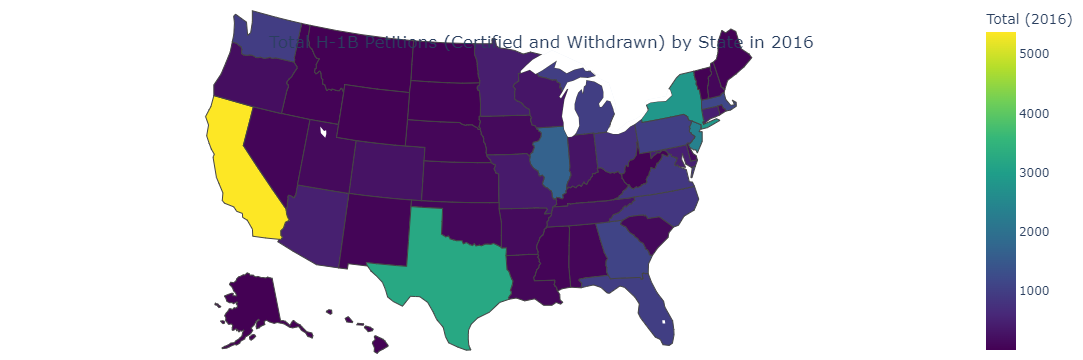

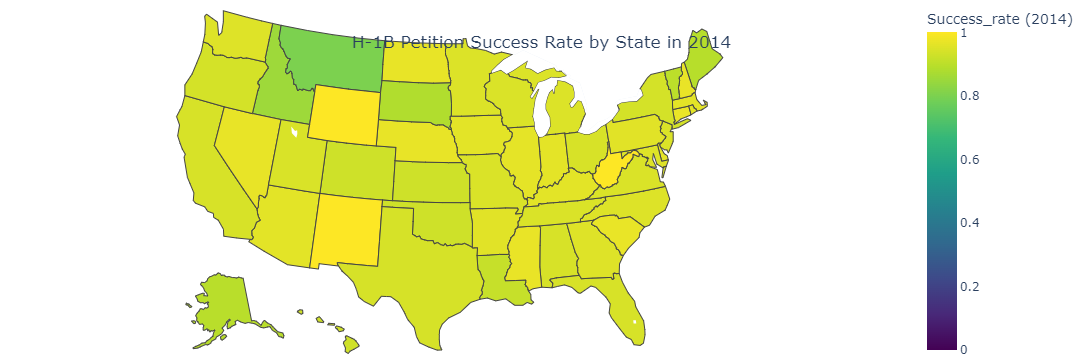

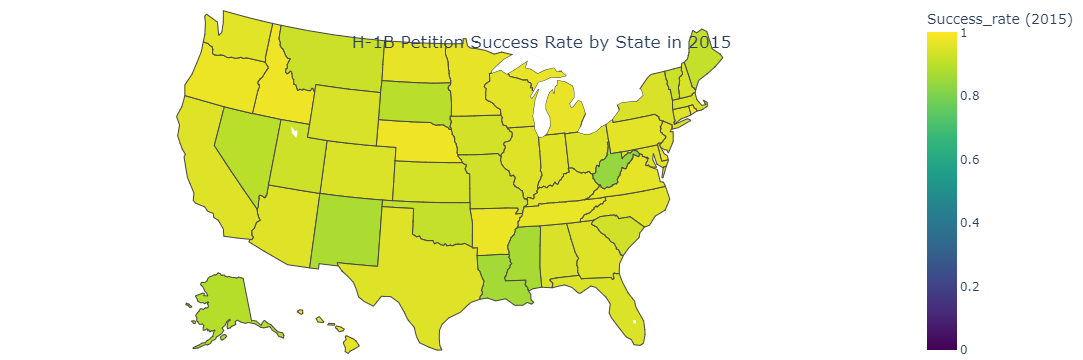

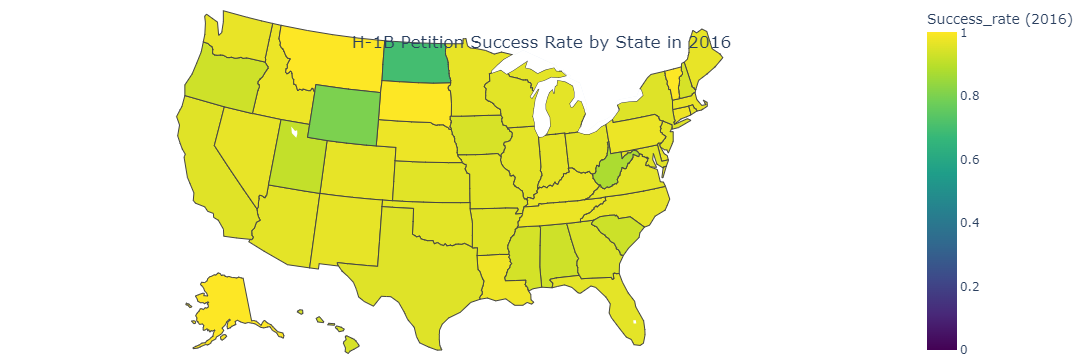

In [61]:
df_sample['successful'] = df_sample['case_status'].isin(['certified', 'certified-withdrawn']).astype(int)
df_sample['worksite_state'] = df_sample['worksite_state'].str.upper()
state_year_data = df_sample.groupby(['year', 'worksite_state']).agg(
    {'case_status': 'count', 'successful': ['sum', 'mean']}
).reset_index()
state_year_data.columns = ['year', 'worksite_state', 'total', 'certified', 'success_rate']

min_success_rate = state_year_data['success_rate'].min()
max_success_rate = state_year_data['success_rate'].max()

def plot_choropleth_map(year, metric):
    year_data = state_year_data[state_year_data['year'] == year]

    if metric == 'total':
        title_text = f'Total H-1B Petitions (Certified and Withdrawn) by State in {year}'
    else:
        title_text = f'H-1B Petition Success Rate by State in {year}'

    fig = px.choropleth(
        year_data,
        locations='worksite_state',
        color=metric,
        color_continuous_scale='Viridis',
        locationmode='USA-states',
        scope='usa',
        labels={metric: f'{metric.capitalize()} ({year})'},
        range_color=(min_success_rate, max_success_rate) if metric == 'success_rate' else None,
    )

    fig.update_layout(
        title={
            'text': title_text,
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        margin={"r":0,"t":0,"l":0,"b":0}
    )

    fig.show()

plot_choropleth_map(2014, 'total')
plot_choropleth_map(2015, 'total')
plot_choropleth_map(2016, 'total')

plot_choropleth_map(2014, 'success_rate')
plot_choropleth_map(2015, 'success_rate')
plot_choropleth_map(2016, 'success_rate')


#### 3.1.4 Results
结果：有的州本身申请量就很少，导致它们的成功率没法和申请量特别多的州直接进行横向比较。在后续分析中，一个可能的办法是去除那些申请量过小的州，使得成功率之间的比较更有意义。

### 3.2 Employer

#### 3.2.1 Which employers file the most petitions each year?  

In [62]:
# number of certified, withdrawn for each employer
employer_petitions_by_year = df_sample.groupby(['year', 'employer_name', 'case_status']).size().reset_index(name='num_petitions')
employer_petitions_by_year = employer_petitions_by_year.pivot_table(index=['year', 'employer_name'], columns='case_status', values='num_petitions', fill_value=0).reset_index()

# success rate
employer_petitions_by_year['total_petitions'] = employer_petitions_by_year['certified'] + employer_petitions_by_year['certified-withdrawn'] + employer_petitions_by_year['denied'] + employer_petitions_by_year['withdrawn']
employer_petitions_by_year['success_rate'] = (employer_petitions_by_year['certified'] + employer_petitions_by_year['certified-withdrawn']) / employer_petitions_by_year['total_petitions']

# ascending rank
employer_petitions_by_year = employer_petitions_by_year.sort_values(['year', 'total_petitions'], ascending=[True, False])

# groupby year
def print_group(group):
    print(f"submitted year: {group['year'].iloc[0]}")
    print(group[['employer_name', 'certified', 'certified-withdrawn', 'denied', 'withdrawn', 'success_rate']].head(10))
    print("\n")

employer_petitions_by_year.groupby('year').apply(print_group)

submitted year: 2010
case_status                        employer_name  certified  \
0                   advanced micro devices, inc.          0   
1                                      akken inc          0   
2                        american airlines, inc.          0   
3             austin independent school district          0   
4            baltimore city public school system          0   
5                                cdi corporation          0   
6             centaurus technology partners, llc          0   
7                                   cummins inc.          0   
8                            emergys corporation          0   
9             experian marketing solutions, inc.          0   

case_status  certified-withdrawn  denied  withdrawn  success_rate  
0                              1       0          0          1.00  
1                              1       0          0          1.00  
2                              1       0          0          1.00  
3            

Empty DataFrame
Columns: []
Index: []

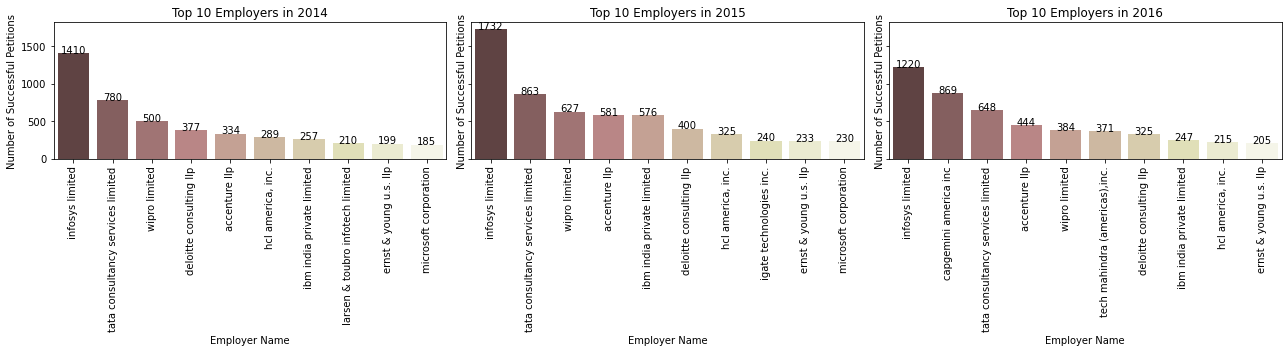

In [70]:
def plot_top_employers(year_data, year, ax):
    top_10_employers = year_data.groupby('employer_name')['certified'].sum().nlargest(10)
    sns.barplot(x=top_10_employers.index, y=top_10_employers.values, palette='pink', ax=ax)
    ax.set_xticklabels(top_10_employers.index, rotation=90)
    ax.set_xlabel("Employer Name")
    ax.set_ylabel("Number of Successful Petitions")
    ax.set_title(f"Top 10 Employers in {year}")

    for index, value in enumerate(top_10_employers.values):
        ax.text(index, value+0.5, str(value), ha='center')

years = [2014, 2015, 2016]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate(years):
    year_data = employer_petitions_by_year[employer_petitions_by_year['year'] == year]
    plot_top_employers(year_data, year, axes[i])

plt.tight_layout()
plt.show()

#### 3.2.2 Results

According to the results above, we can find that the employers file the most petitions in each year are infosys limited. 16年出现了新公司排第二

### 3.3 Job

#### 3.3.1 What jobs with the highest number of applications each year?

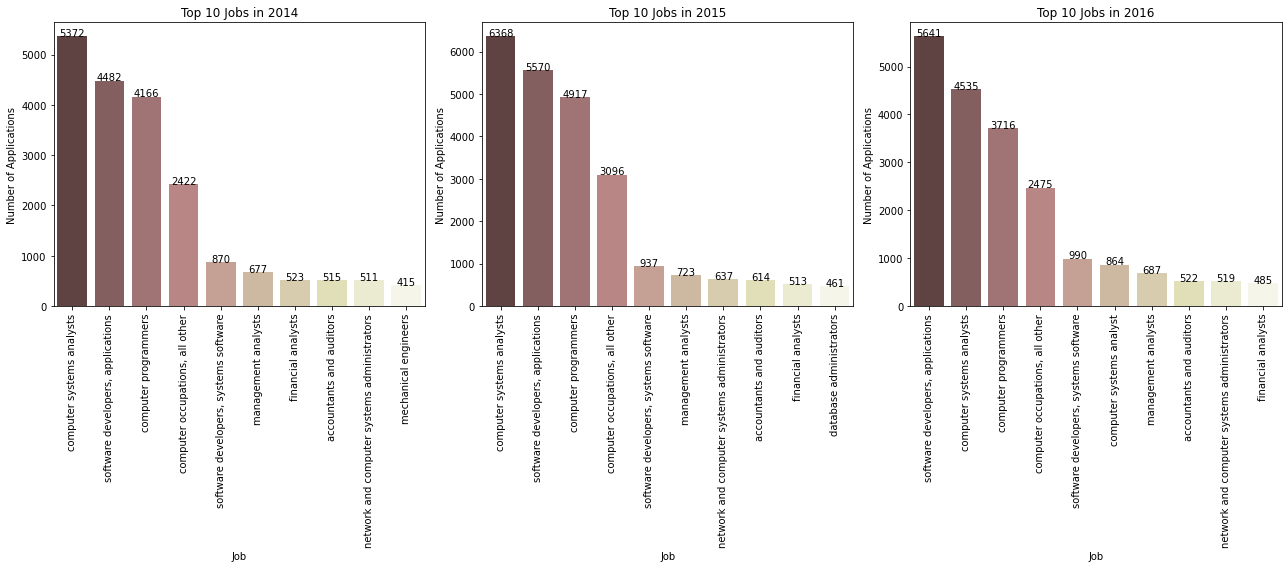

In [72]:
years = [2014, 2015, 2016]

fig, axs = plt.subplots(1, 3, figsize=(18, 8))

for i, year in enumerate(years):
    year_data = df_sample[df_sample['year'] == year]
    top_10_jobs = year_data['soc_name'].value_counts().nlargest(10)

    ax = sns.barplot(x=top_10_jobs.index, y=top_10_jobs.values, palette='pink', ax=axs[i])
    ax.set_xticklabels(top_10_jobs.index, rotation=90)
    ax.set_xlabel("Job")
    ax.set_ylabel("Number of Applications")
    ax.set_title(f"Top 10 Jobs in {year}")

    for index, value in enumerate(top_10_jobs.values):
        ax.text(index, value+0.5, str(value), ha='center')

plt.tight_layout()
plt.show()

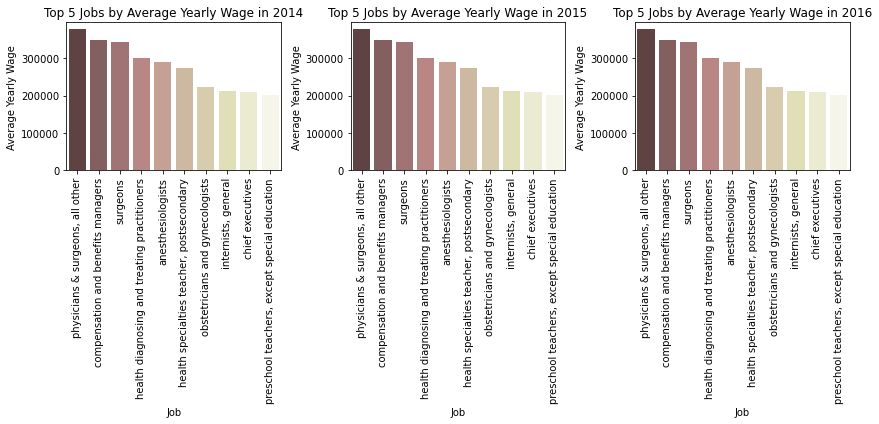

In [73]:
years = [2014, 2015, 2016]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, year in enumerate(years):
    year_data = df_yearly[df_yearly['year'] == year]
    top_10_avg_wages = df_yearly.groupby('soc_name')['calculated_wage'].mean().nlargest(10)
    
    ax = sns.barplot(x=top_10_avg_wages.index, y=top_10_avg_wages.values, palette='pink', ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_xlabel("Job")
    axes[i].set_ylabel("Average Yearly Wage")
    axes[i].set_title(f"Top 5 Jobs by Average Yearly Wage in {year}")

    
plt.tight_layout()
plt.show()

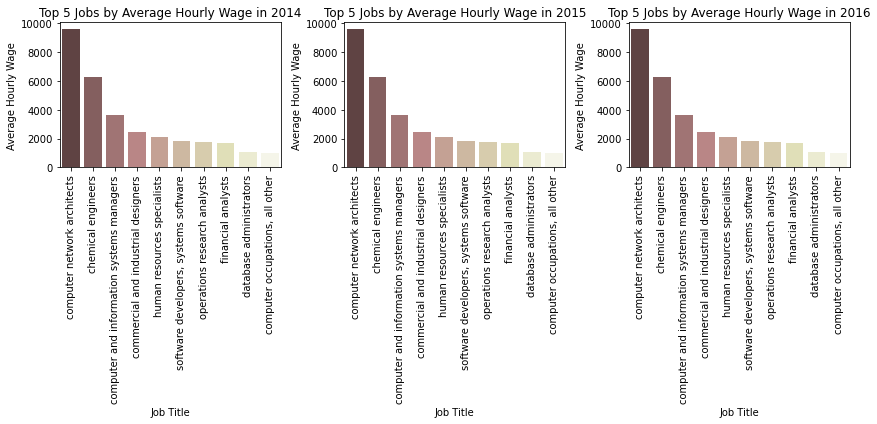

In [78]:
years = [2014, 2015, 2016]

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

for i, year in enumerate(years):
    year_data = df_hourly[df_hourly['year'] == year]
    top_10_avg_wages = df_hourly.groupby('soc_name')['calculated_wage'].mean().nlargest(10)
    
    ax = sns.barplot(x=top_10_avg_wages.index, y=top_10_avg_wages.values, palette='pink', ax=axes[i])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_xlabel("Job Title")
    axes[i].set_ylabel("Average Hourly Wage")
    axes[i].set_title(f"Top 5 Jobs by Average Hourly Wage in {year}")

    
plt.tight_layout()
plt.show()

检查一下copy writer的数量,分布，工资构成。

#### 3.3.2 What is the number of successful and failed applications for each job?

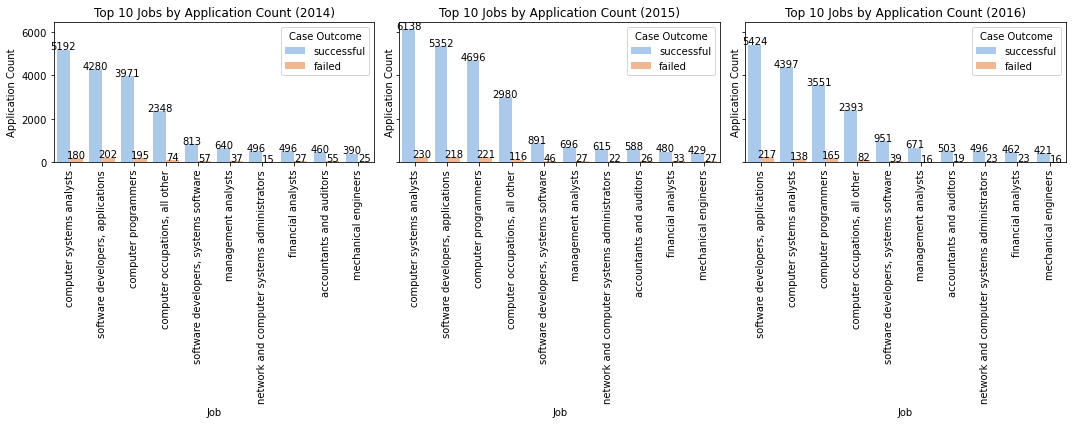

In [83]:
years = [2014, 2015, 2016]

# Calculate total applications and successful applications for each job title by year
job_yearly_data = df_sample.groupby(['year', 'soc_name', 'case_outcome']).agg({'successful_petition': 'count'}).reset_index()
job_yearly_data.columns = ['year', 'soc_name', 'case_outcome', 'application_count']

# Find top 10 job titles by total applications
top_10_jobs = job_yearly_data.groupby('soc_name')['application_count'].sum().nlargest(10).index

# Filter data for top 10 job titles
top_10_job_data = job_yearly_data[job_yearly_data['soc_name'].isin(top_10_jobs)].copy()

# Reorder job titles by total applications
top_10_job_data['job_title'] = pd.Categorical(top_10_job_data['soc_name'], categories=top_10_jobs, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for idx, year in enumerate(years):
    data_year = top_10_job_data[top_10_job_data['year'] == year]
    data_year = data_year.sort_values(by='application_count', ascending=False)

    ax = sns.barplot(data=data_year, x='soc_name', y='application_count', hue='case_outcome', hue_order=['successful', 'failed'], ax=axes[idx], palette='pastel')
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel("Job")
    axes[idx].set_ylabel("Application Count")
    axes[idx].set_title(f"Top 10 Jobs by Application Count ({year})")
    axes[idx].legend(title='Case Outcome', loc='upper right')
    
    # Add the application counts as annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()
plt.show()

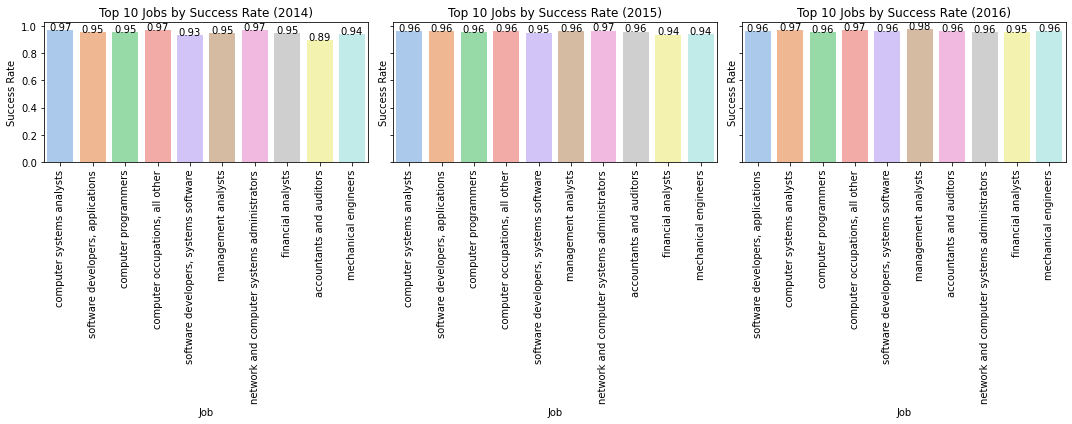

In [93]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for idx, year in enumerate(years):
    data_year = top_10_job_data[top_10_job_data['year'] == year]
    data_year = data_year.sort_values(by='application_count', ascending=False)

    # Calculate success rate for each job title
    success_data = data_year[data_year['case_outcome'] == 'successful'][['soc_name', 'application_count']]
    total_data = data_year[['soc_name', 'application_count']].groupby('soc_name').sum()
    success_rate_data = success_data.join(total_data, on='soc_name', how='left', lsuffix='_success', rsuffix='_total')
    success_rate_data['success_rate'] = success_rate_data['application_count_success'] / success_rate_data['application_count_total']

    ax = sns.barplot(data=success_rate_data, x='soc_name', y='success_rate', ax=axes[idx], palette='pastel')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Job")
    ax.set_ylabel("Success Rate")
    ax.set_title(f"Top 10 Jobs by Success Rate ({year})")

    # Add the success rates as annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.tight_layout()
plt.show()

IT行业更倾向于以年薪来申报。从年薪来看program analyst收入是所有申请的职业中最高的。

### 3.4 Wages

#### 3.4.1 Is the applicant wage correlated with petition success?   

在这个部分，我分别对年薪和时薪进行了薪资水平的分组，并使用逻辑回归计算了不同薪资水平与申请通过的相关性，结果显示二者不存在明显的相关性。因此我结合了其他外部数据，探索在不同的分组下薪资和成功的申请间是否存在相关性，以及这些存在相关性的因子是怎么影响申请结果的，是否可以通过建立预测模型，来判断具备哪些特征的申请case更可能成功。

*3.4.1部分仅供展示分析过程，无需运行。可直接跳至3.5

##### a. yearly-wages

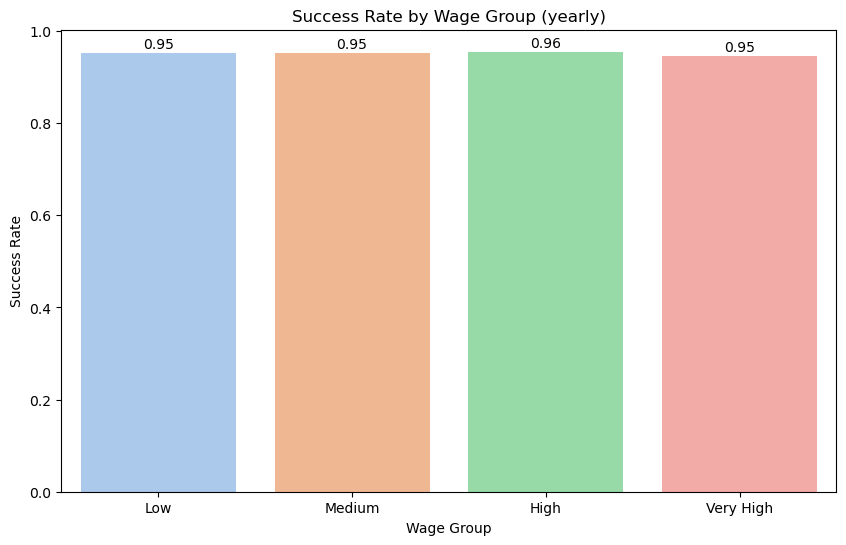

In [72]:
df_yearly_copy = df_yearly.copy()

df_yearly_copy['successful_petition'] = np.where(df_yearly_copy['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

# set groups
wage_bins = [30000, 80000, 100000, 150000, np.inf]  
wage_labels = ['Low', 'Medium', 'High', 'Very High']
df_yearly_copy['wage_group'] = pd.cut(df_yearly_copy['calculated_wage'], bins=wage_bins, labels=wage_labels)

# calculate certified rate
grouped_data = df_yearly_copy.groupby('wage_group')['successful_petition'].mean().reset_index()

# Handle non-finite values
grouped_data['successful_petition'] = grouped_data['successful_petition'].fillna(0)

# visualise 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='wage_group', y='successful_petition', palette='pastel')
plt.xlabel("Wage Group")
plt.ylabel("Success Rate")
plt.title("Success Rate by Wage Group (yearly)")

for index, row in grouped_data.iterrows():
    ax.text(index, row['successful_petition'] + 0.01, round(row['successful_petition'], 2), color='black', ha='center')

plt.show()

Logistical regression

In [74]:
df_yearly_copy = df_yearly_copy.dropna(subset=['calculated_wage'])

X = df_yearly_copy[['calculated_wage']]
y = df_yearly_copy['successful_petition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

# report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9526622608640062
ROC AUC Score: 0.5


C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     23695
           1       0.95      1.00      0.98    476857

    accuracy                           0.95    500552
   macro avg       0.48      0.50      0.49    500552
weighted avg       0.91      0.95      0.93    500552



C:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



##### b. hourly wages

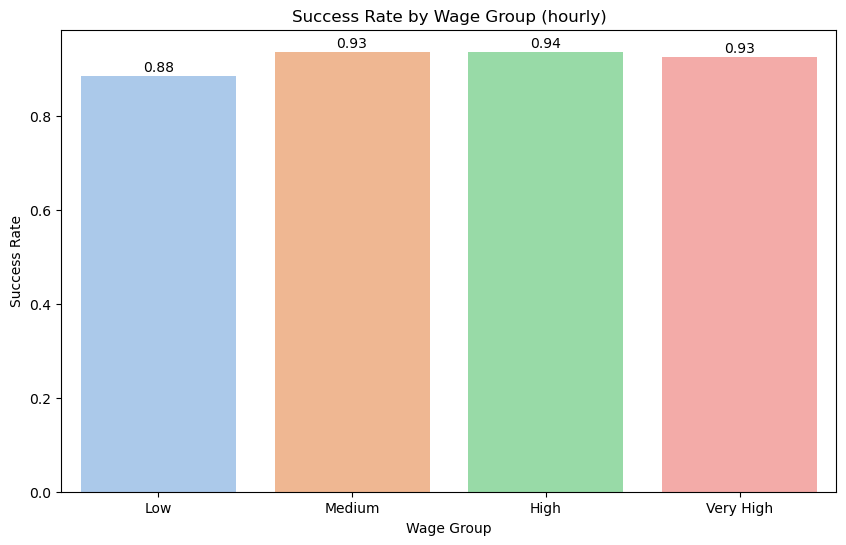

In [76]:
df_hourly_copy = df_hourly.copy()

df_hourly_copy['successful_petition'] = np.where(df_hourly_copy['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

# set groups
wage_bins = [0, 27.5, 32.14, 39.575, np.inf]  
wage_labels = ['Low', 'Medium', 'High', 'Very High']
df_hourly_copy['wage_group'] = pd.cut(df_hourly_copy['calculated_wage'], bins=wage_bins, labels=wage_labels)

# calculate certified rate
grouped_data = df_hourly_copy.groupby('wage_group')['successful_petition'].mean().reset_index()

# visualise 
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=grouped_data, x='wage_group', y='successful_petition', palette='pastel')
plt.xlabel("Wage Group")
plt.ylabel("Success Rate")
plt.title("Success Rate by Wage Group (hourly)")

for index, row in grouped_data.iterrows():
    ax.text(index, row['successful_petition'] + 0.01, round(row['successful_petition'], 2), color='black', ha='center')

plt.show()

In [77]:
# 划分数据集
X = df_hourly_copy[['calculated_wage']]
y = df_hourly_copy['successful_petition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练逻辑回归模型
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# 预测
y_pred = log_reg.predict(X_test)

# 评估模型性能
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9191433566433567
ROC AUC Score: 0.5135655921217437
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.03      0.05      2829
           1       0.92      1.00      0.96     31491

    accuracy                           0.92     34320
   macro avg       0.84      0.51      0.51     34320
weighted avg       0.91      0.92      0.88     34320



### 3.5 Bonus

#### 3.5.1 Merge extra data

Add more data columns from other data sources to augment your analysis.

美国的The Standard Occupational Classification (SOC) Code system是根据一定的层级结构分类的。SOC系统包括5个层级，从大到小分别是：

Major group
Minor group
Broad occupation
Detailed occupation
Specific occupation
其中，Major group是最高层级，包含23个大类。每个大类都有一个两位数的代码。Minor group是下一个层级，包含96个小类。每个小类都有一个三位数的代码。Broad occupation是第三个层级，包含459个职业类别。每个职业类别都有一个四位数的代码。Detailed occupation是第四个层级，包含839个职业类别。每个职业类别都有一个五位数的代码。Specific occupation是最小的层级，包含1305个职业类别。每个职业类别都有一个六位数的代码。

In [98]:
occupations = {
    '11-0000': 'Management Occupations',
    '13-0000': 'Business and Financial Operations Occupations',
    '15-0000': 'Computer and Mathematical Occupations',
    '17-0000': 'Architecture and Engineering Occupations',
    '19-0000': 'Life, Physical, and Social Science Occupations',
    '21-0000': 'Community and Social Service Occupations',
    '23-0000': 'Legal Occupations',
    '25-0000': 'Education, Training, and Library Occupations',
    '27-0000': 'Arts, Design, Entertainment, Sports, and Media Occupations',
    '29-0000': 'Healthcare Practitioners and Technical Occupations',
    '31-0000': 'Healthcare Support Occupations',
    '33-0000': 'Protective Service Occupations',
    '35-0000': 'Food Preparation and Serving Related Occupations',
    '37-0000': 'Building and Grounds Cleaning and Maintenance Occupations',
    '39-0000': 'Personal Care and Service Occupations',
    '41-0000': 'Sales and Related Occupations',
    '43-0000': 'Office and Administrative Support Occupations',
    '45-0000': 'Farming, Fishing, and Forestry Occupations',
    '47-0000': 'Construction and Extraction Occupations',
    '49-0000': 'Installation, Maintenance, and Repair Occupations',
    '51-0000': 'Production Occupations',
    '53-0000': 'Transportation and Material Moving Occupations',
    '55-0000': 'Military Specific Occupations'
}

# dictionary transfers to DataFrame
df_occupations = pd.DataFrame(list(occupations.items()), columns=['soc_code_major', 'occupation'])

print(df_occupations)

   soc_code_major                                         occupation
0         11-0000                             Management Occupations
1         13-0000      Business and Financial Operations Occupations
2         15-0000              Computer and Mathematical Occupations
3         17-0000           Architecture and Engineering Occupations
4         19-0000     Life, Physical, and Social Science Occupations
5         21-0000           Community and Social Service Occupations
6         23-0000                                  Legal Occupations
7         25-0000       Education, Training, and Library Occupations
8         27-0000  Arts, Design, Entertainment, Sports, and Media...
9         29-0000  Healthcare Practitioners and Technical Occupat...
10        31-0000                     Healthcare Support Occupations
11        33-0000                     Protective Service Occupations
12        35-0000   Food Preparation and Serving Related Occupations
13        37-0000  Building and Gr

In [122]:
df_sample['soc_code_major'] = df_sample['soc_code'].str[:2]
df_yearly['soc_code_major'] = df_yearly['soc_code'].str[:2]
df_hourly['soc_code_major'] = df_hourly['soc_code'].str[:2]

df_occupations['soc_code_major'] = df_occupations['soc_code_major'].str[:2]

df_sample = pd.merge(df_sample, df_occupations, on='soc_code_major', how='left')
df_yearly = pd.merge(df_yearly, df_occupations, on='soc_code_major', how='left')
df_hourly = pd.merge(df_hourly, df_occupations, on='soc_code_major', how='left')

In [124]:
df_yearly['successful_petition'] = np.where(df_yearly['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)
df_hourly['successful_petition'] = np.where(df_hourly['case_status'].isin(['certified', 'certified-withdrawn']), 1, 0)

In [125]:
df_yearly.head()

case_number          case_status      case_submitted  \
0  i-200-13010-977913            withdrawn 2014-01-10 19:19:02   
1  i-200-15064-010974  certified-withdrawn 2015-03-05 00:00:00   
2  i-200-16118-472113            certified 2016-04-27 00:00:00   
3  i-200-16083-744641            certified 2016-03-23 00:00:00   
4  i-200-15064-131562            certified 2015-03-05 00:00:00   

        decision_date visa_class employment_start_date employment_end_date  \
0 2014-01-15 16:03:04       h-1b                   NaN                 NaN   
1 2015-09-25 00:00:00       h-1b            09/01/2015          06/30/2018   
2 2016-05-03 00:00:00       h-1b                   NaN                 NaN   
3 2016-03-29 00:00:00       h-1b                   NaN                 NaN   
4 2015-03-11 00:00:00       h-1b            09/04/2015          09/03/2018   

                       employer_name  \
0               rtkl associates inc.   
1                   ang infotech llc   
2                     technogen inc.   
3  verinon technology solutions ltd.   
4              vsquare infotech inc.   

                           employer_address      employer_city employer_state  \
0                     901 south bond street          baltimore             md   
1                          23 sequoia drive             dayton             nj   
2                  4229 lafayette center dr          chantilly             va   
3         3395 north arlington heights road  arlington heights             il   
4  485 us highway 1 s building c, suite 105             iselin             nj   

  employer_postal_code soc_code                                soc_name  \
0                21231  17-1011  architects, except landscape and naval   
1                08810  15-1121               computer systems analysts   
2                20151  11-2022                          sales managers   
3                60004  15-1121               computer systems analysts   
4                08830  15-1131                    computer programmers   

                        job_title  wage_rate_of_pay_from  wage_rate_of_pay_to  \
0                intern architect               48175.00                  NaN   
1                 systems analyst                    NaN                  NaN   
2  manager , sales and operations              120000.00                  NaN   
3                     it analayst               56514.00                  NaN   
4              programmer analyst                    NaN                  NaN   

  wage_unit_of_pay full_time_position  total_workers      worksite_city  \
0             year                  y           1.00        los angeles   
1             year                  y            NaN           new york   
2             year                NaN           1.00          chantilly   
3             year                NaN           1.00  arlington heights   
4             year                  y            NaN           bluffton   

  worksite_state  prevailing_wage pw_unit_of_pay pw_wage_source  \
0             ca         46400.00           year          other   
1             ny         63086.00           year            oes   
2             va        110448.00           year            oes   
3             il         56514.00           year            oes   
4             sc         36566.00           year          other   

                pw_source_other  pw_source_year  naic_code  \
0  2013 aia compensation report         2013.00  541310.00   
1                           NaN             NaN  541511.00   
2       oflc online data center         2015.00  541511.00   
3       oflc online data center         2015.00  541511.00   
4                           NaN             NaN  541511.00   

           employer_country  total workers pw_wage_level  pw_wage_source_year  \
0                       NaN            NaN           NaN                  NaN   
1  united states of america           1.00       level i              2014.00   
2  unite

In [101]:
value_counts = df_sample['occupation'].value_counts()
print(value_counts.head(10))

Computer and Mathematical Occupations                         67890
Business and Financial Operations Occupations                  8712
Architecture and Engineering Occupations                       6726
Life, Physical, and Social Science Occupations                 3790
Management Occupations                                         3669
Healthcare Practitioners and Technical Occupations             3522
Education, Training, and Library Occupations                   2629
Arts, Design, Entertainment, Sports, and Media Occupations     1667
Sales and Related Occupations                                   524
Legal Occupations                                               400
Name: occupation, dtype: int64


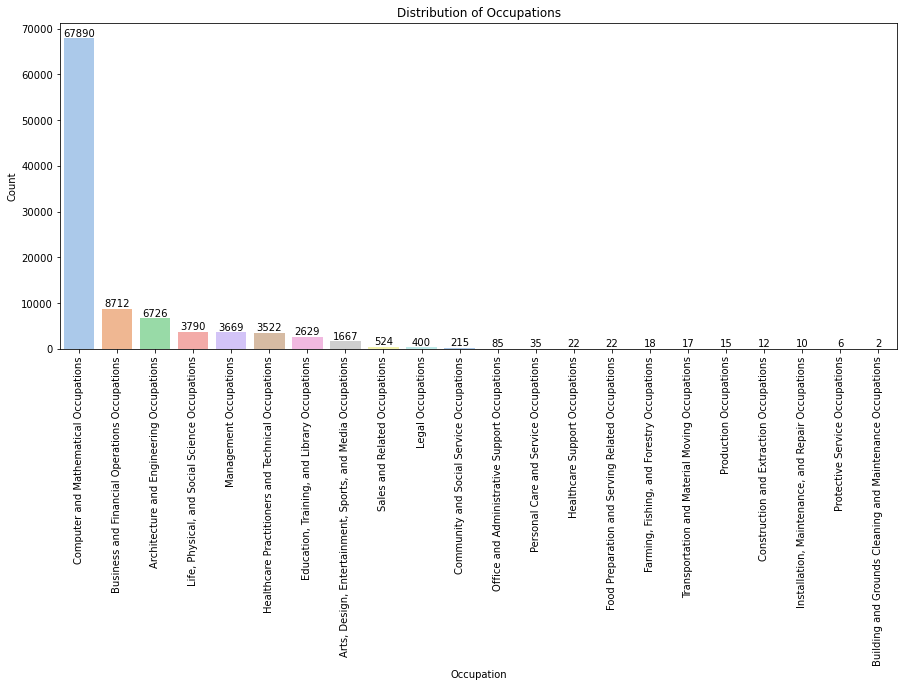

In [128]:
plt.figure(figsize=(15,6))
sns.countplot(data=df_sample, x='occupation', palette='pastel', order=value_counts.index)
plt.xticks(rotation=90)
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.title("Distribution of Occupations")

for i, v in enumerate(value_counts.values):
    ax[i].set_height(v)
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom')
    
plt.show()

分组分析：将数据集按照职位、雇主、行业或地理位置进行分组，计算每组的平均薪资和签证通过率，从而了解各组之间的差异。

先区分hourly和yearly wages，然后：
    · groupby：
        职位
        雇主
        行业（occupation）
        州
    · 分别计算每组内的平均薪资和签证通过率；
    · 计算每组内的相关性
    

#### 3.5.2 分组分析
##### a. yearly wages- grouped_df_yearlyoccupation group

In [158]:
print(grouped_by_occupation)

In [129]:
grouped_df_yearly = df_yearly.groupby(['occupation'])[['successful_petition', 'calculated_wage']].agg(['count', 'sum', 'mean'])

#,'soc_name', 'employer_name', 'worksite_state'
# 通过率 = 成功申请数量 / 总申请数量
grouped_df_yearly['success_rate'] = grouped_df_yearly['successful_petition', 'sum'] / grouped_df_yearly['successful_petition', 'count']

# 重置索引
grouped_df_yearly = grouped_df_yearly.sort_values(by='success_rate', ascending=False)
grouped_df_yearly.reset_index(inplace=True)

# 查看分组分析结果
print(grouped_df_yearly)

                                           occupation successful_petition  \
                                                                    count   
0   Building and Grounds Cleaning and Maintenance ...                   1   
1                      Protective Service Occupations                   2   
2               Computer and Mathematical Occupations               65572   
3       Business and Financial Operations Occupations                7599   
4      Life, Physical, and Social Science Occupations                3527   
5        Education, Training, and Library Occupations                2339   
6            Architecture and Engineering Occupations                6196   
7   Healthcare Practitioners and Technical Occupat...                2392   
8                              Management Occupations                3317   
9                       Sales and Related Occupations                 481   
10  Arts, Design, Entertainment, Sports, and Media...                1319   

In [159]:
# Group by occupation
grouped_by_occupation = df_yearly.groupby('occupation')

# Initialize an empty list to store the results
correlation_results_list = []

# Iterate over the occupation groups and calculate the correlation
for occupation, group_data in grouped_by_occupation:
    correlation = group_data['calculated_wage'].corr(group_data['successful_petition'])
    avg_wage = group_data['calculated_wage'].mean()
    total_petitions = group_data['successful_petition'].count()
    successful_petitions = group_data['successful_petition'].sum()
    success_rate = successful_petitions / total_petitions

    # Append the result to the correlation_results_list
    correlation_results_list.append(
        pd.DataFrame({
            'occupation': [occupation],
            'average_wage': [avg_wage],
            'total_petitions': [total_petitions],
            'successful_petitions': [successful_petitions],
            'success_rate': [success_rate],
            'correlation': [correlation]
        })
    )

# Concatenate the list of DataFrames into a single DataFrame
correlation_results = pd.concat(correlation_results_list, ignore_index=True)

# Sort the results by correlation in descending order
correlation_results = correlation_results.sort_values(by='total_petitions', ascending=False)

# Display the results
print(correlation_results)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning:

Degrees of freedom <= 0 for slice

/opt/conda/envs/sds2021/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning:

divide by zero encountered in true_divide



                                           occupation  average_wage  \
5               Computer and Mathematical Occupations      82829.17   
3       Business and Financial Operations Occupations      82772.72   
0            Architecture and Engineering Occupations      86733.46   
14     Life, Physical, and Social Science Occupations      65563.98   
15                             Management Occupations     130768.35   
10  Healthcare Practitioners and Technical Occupat...     144629.89   
7        Education, Training, and Library Occupations      76868.59   
1   Arts, Design, Entertainment, Sports, and Media...      68132.95   
20                      Sales and Related Occupations     103393.92   
13                                  Legal Occupations     140105.39   
4            Community and Social Service Occupations      47696.37   
16      Office and Administrative Support Occupations      46462.90   
17              Personal Care and Service Occupations      33438.76   
9    F

In [157]:
# Group by occupation
grouped_by_occupation = df_yearly.groupby('occupation')
['success_rate'] = grouped_df_yearly['successful_petition', 'sum'] / grouped_df_yearly['successful_petition', 'count']

# Initialize an empty list to store the results
correlation_results_list = []

# Iterate over the occupation groups and calculate the correlation
for occupation, group_data in grouped_by_occupation:
    correlation = group_data['calculated_wage'].corr(group_data['successful_petition'])
    avg_wage = group_data['calculated_wage'].mean()
    total_petitions = group_data['successful_petition'].count()
    successful_petitions = group_data['successful_petition'].sum()
    success_rate = successful_petitions / total_petitions
    wage_success_rate_corr = group_data['calculated_wage'].corr(group_data['success_rate'])

    # Append the result to the correlation_results_list
    correlation_results_list.append(
        pd.DataFrame({
            'occupation': [occupation],
            'average_wage': [avg_wage],
            'total_petitions': [total_petitions],
            'successful_petitions': [successful_petitions],
            'success_rate': [success_rate],
            'correlation': [correlation],
            'wage_success_rate_corr': [wage_success_rate_corr]
        })
    )

# Concatenate the list of DataFrames into a single DataFrame
correlation_results = pd.concat(correlation_results_list, ignore_index=True)

# Sort the results by correlation in descending order
correlation_results = correlation_results.sort_values(by='total_petitions', ascending=False)

# Display the results
print(correlation_results)

/tmp/ipykernel_620/3650031243.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



KeyError: "Columns not found: 'sum'"

In [149]:
# Group by worksite
grouped_by_worksite_state = df_yearly.groupby('worksite_state')

# Initialize an empty list to store the results
results_list = []

# Iterate over the occupation groups and fit a logistic regression model
for worksite_state, group_data in grouped_by_worksite_state:
    X = group_data[['calculated_wage']]
    y = group_data['successful_petition']

    if len(y.unique()) > 1:
        model = LogisticRegression()
        model.fit(X, y)
        coef = model.coef_[0][0]
    else:
        coef = None

    avg_wage = group_data['calculated_wage'].mean()
    total_petitions = group_data['successful_petition'].count()
    successful_petitions = group_data['successful_petition'].sum()
    success_rate = successful_petitions / total_petitions

    # Append the result to the results_list
    results_list.append(
        pd.DataFrame({
            'worksite_state': [worksite_state],
            'average_wage': [avg_wage],
            'total_petitions': [total_petitions],
            'successful_petitions': [successful_petitions],
            'success_rate': [success_rate],
            'coefficient': [coef]
        })
    )

# Concatenate the list of DataFrames into a single DataFrame
results = pd.concat(results_list, ignore_index=True)

# Sort the results by coefficient in descending order (ignoring rows with None)
results = results[results['coefficient'].notnull()].sort_values(by='total_petitions', ascending=False)

# Display the results
print(results)

   worksite_state  average_wage  total_petitions  successful_petitions  \
4              ca      99118.50            17207                 16326   
48             tx      79327.47             9664                  9158   
38             ny      93454.85             8143                  7693   
35             nj      77460.33             7145                  6823   
16             il      82658.39             5142                  4936   
21             ma      86897.64             3701                  3524   
11             ga      80091.84             3477                  3302   
42             pa      81351.80             3381                  3256   
53             wa      99437.58             3350                  3215   
9              fl      77261.03             3012                  2865   
50             va      79662.80             2817                  2697   
31             nc      81444.65             2678                  2557   
25             mi      75340.74       

In [151]:
# Group by occupation
grouped_by_occupation = df_hourly.groupby('occupation')

# Initialize an empty list to store the results
results_list = []

# Iterate over the occupation groups and fit a logistic regression model
for occupation, group_data in grouped_by_occupation:
    X = group_data[['calculated_wage']]
    y = group_data['successful_rate']

    if len(y.unique()) > 1:
        model = LogisticRegression()
        model.fit(X, y)
        coef = model.coef_[0][0]
    else:
        coef = None

    avg_wage = group_data['calculated_wage'].mean()
    total_petitions = group_data['successful_petition'].count()
    successful_petitions = group_data['successful_petition'].sum()
    success_rate = successful_petitions / total_petitions

    # Append the result to the results_list
    results_list.append(
        pd.DataFrame({
            'occupation': [occupation],
            'average_wage': [avg_wage],
            'total_petitions': [total_petitions],
            'successful_petitions': [successful_petitions],
            'success_rate': [success_rate],
            'coefficient': [coef]
        })
    )

# Concatenate the list of DataFrames into a single DataFrame
results = pd.concat(results_list, ignore_index=True)

# Sort the results by coefficient in descending order (ignoring rows with None)
results = results[results['coefficient'].notnull()].sort_values(by='total_petitions', ascending=False)

# Display the results
print(results)

KeyError: 'successful_rate'

/tmp/ipykernel_620/3088001312.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



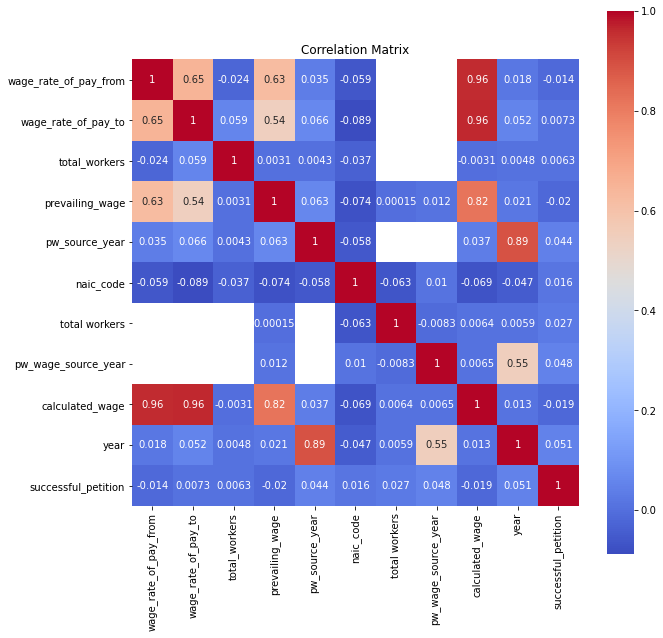

In [150]:
# 计算相关性矩阵
correlation_matrix = df_yearly.corr()

# 使用Seaborn绘制热力图
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)

# 设置标题
plt.title("Correlation Matrix")

# 显示图像
plt.show()

##### c. results

根据以上的逻辑回归和随机森林模型结果，工资水平（年薪和时薪）与申请的成功与否无直接关系。

但是，考虑到不同职业的薪资水平差异很大，同时它们的申请成功率也可能有很大差异。职业类型可能是影响申请成功率的一个重要因素，而这个因素可能在您的分析中被忽略了。
不仅按薪资区间，也按职业来区分，计算相关性。

#### 思路(5.8)


b. 数据分析   
画出每年df_sample中的soc_code_major数量分布，并列出每年的前十的occupations；   
根据职业大类soc_code_major分组，每组内考虑薪资等级（pw unit不为空的情况下），再在每个组内计算薪资和申请成功的相关性。   

5.9
在完整数据集中跑一遍，并写results